In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from bisect import *
from collections import Counter
import os
# from operator import itemgetter
# import scipy.interpolate

pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)

In [2]:
# the bormhub folder goes in the same dropbox folder where notes are synced
current_path = os.path.abspath("")
directory = os.path.dirname(current_path)
results_directory = rf"{directory}\bormhub_results"
notes_directory = rf"{directory}\Notes"
filename_list = ['Lifting 2025', 'Lifting 2024', '5x5']
path_list = [ rf"{notes_directory}\{x}.md" for x in filename_list ]

In [3]:
def borm_calc(rep,weight_c):
    # https://stackoverflow.com/questions/26071855/remove-everything-but-leave-numbers-and-dots
    weight_c = float(re.sub('[^\d\.]', '', weight_c))
    if rep == 0:
        return float(0)
    # if reps <= 10, use Brzycki formula for borm
    elif rep <= 10:
        return weight_c*36/(37-rep)
    # if reps > 10, use Epley formula
    else:
        return weight_c*(1+0.0333*rep)
    
def borm_list_maker(rep_count,weight_c):
    borm_list = []
    for rep in rep_count:
        borm_list.append(borm_calc(rep,weight_c))
    return borm_list

In [4]:
full_file_df = pd.concat( [ pd.read_csv(csv, sep="      ", header=None) for csv in path_list ] )

results = {}
borm_results = {}
date_c = "nah"
lift_c = "nah"
weight_c = "nah"
rep_c = "nah"

bodyweight_exercises = []

date_flag = "### "
lift_flag = "> "
weight_flag = ">> "
bodyweight_flag = "bw"

for idx, row in full_file_df.iterrows():
    info:str = row[0]
    # print(info)

    rep_count = pd.to_numeric(info, errors="coerce")

    if info.startswith(date_flag):
        date_c = info[len(date_flag):]
        results[date_c] = {}
        borm_results[date_c] = {}

    elif info.startswith(lift_flag):
        lift_c = info[len(lift_flag):]
        if lift_flag not in results[date_c]:
            results[date_c][lift_c] = {}
            borm_results[date_c][lift_c] = {}

    elif info.startswith(weight_flag):
        weight_c = info[len(weight_flag):]
        if weight_c not in results[date_c][lift_c]:
            results[date_c][lift_c][weight_c] = []
            borm_results[date_c][lift_c][weight_c] = []

    elif np.isnan(rep_count):
        if info.startswith("L ") | info.startswith("R "):
            rep_count = info.replace(" ","")
            if info.startswith("L "):
                rep_count = rep_count[1:].split('R')
            else:
                rep_count = rep_count[1:].split('L')
                # reverse so L is always first
                rep_count = list(reversed(rep_count))

            rep_count = [ float(x) for x in rep_count ]
            results[date_c][lift_c][weight_c].append(rep_count)
            borm_results[date_c][lift_c][weight_c].append(borm_list_maker(rep_count,weight_c))
            
    elif not np.isnan(rep_count):
        rep_count = float(rep_count)
        results[date_c][lift_c][weight_c].append(rep_count)
        borm_results[date_c][lift_c][weight_c].append(borm_calc(rep_count,weight_c))


C:\Users\josch\AppData\Local\Temp\ipykernel_7096\3918631055.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  full_file_df = pd.concat( [ pd.read_csv(csv, sep="      ", header=None) for csv in path_list ] )
C:\Users\josch\AppData\Local\Temp\ipykernel_7096\3918631055.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  full_file_df = pd.concat( [ pd.read_csv(csv, sep="      ", header=None) for csv in path_list ] )
C:\Users\josch\AppData\Local\Temp\ipykernel_7096\3918631055.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 ch

In [5]:
# make a json of the results
import json
with open(rf'{results_directory}\results.json', 'w+') as f:
    json.dump(results, f)
with open(rf'{results_directory}\borm_results.json', 'w+') as f:
    json.dump(borm_results, f)

In [6]:
# this function could be simpler
def liftanalyser(current_lift):
    date_list = []
    weight_list = []
    borm_list = []
    rep_list = []
    bodyweight_check = False
    unilateral_check = False

    for date in results:
        max_weight = 0
        max_borm = 0
        max_lborm = 0
        max_rborm = 0
        max_reps = 0

        for lift in results[date]:
            if lift == current_lift:
                date_list.append(date)
                for weight in results[date][lift]:
                    max_reps_at_current_weight = 0
                    for reps in results[date][lift][weight]:
                        if type(reps) is list:
                            reps = sum(reps)
                        max_reps_at_current_weight = max(max_reps_at_current_weight, reps)
                        max_reps = max(max_reps, reps)
                    
                    # check if it's a bodyweight lift
                    if bodyweight_check == True:
                        pass
                    elif weight.endswith("bw"):
                        bodyweight_check = True
                    
                    # else it's not a bodyweight lift
                    else:
                        clean_weight = float(re.sub('[^\d\.]', '', weight))

                        # also check if zero reps were done at that weight, in which case it doesn't count as a max weight
                        if clean_weight > max_weight and max_reps_at_current_weight:
                            max_weight = clean_weight
                        
                        # find the biggest borm
                        for borm in borm_results[date][lift][weight]:
                            if type(borm) == float:
                                if borm > max_borm:
                                    max_borm = borm

                            
                            # if borm is unilateral, make a list of the borms
                            elif len(borm) == 2:
                                unilateral_check = True
                                lborm = borm[0]
                                if lborm > max_lborm:
                                    max_lborm = lborm
                                rborm = borm[1]
                                if rborm > max_rborm:
                                    max_rborm = rborm
                                
                                # lborm always comes first
                                max_borm = [max_lborm,max_rborm]

                            # if borm is some other weird shape
                            else: 
                                sys.exit("Strange borm: ",borm)

                # if it's a bodyweight lift, weight and borm will be full of 0
                rep_list.append(max_reps)
                weight_list.append(max_weight)
                borm_list.append(max_borm)

    date_list = pd.to_datetime(date_list, format="%Y-%m-%d")
    lift_df = pd.DataFrame({'Weight': weight_list, 'Borm': borm_list, 'Reps': rep_list}, index=date_list)
    lift_info = pd.DataFrame({'UniCheck': unilateral_check, 'BWCheck': bodyweight_check}, index=[current_lift])
    return lift_df, lift_info

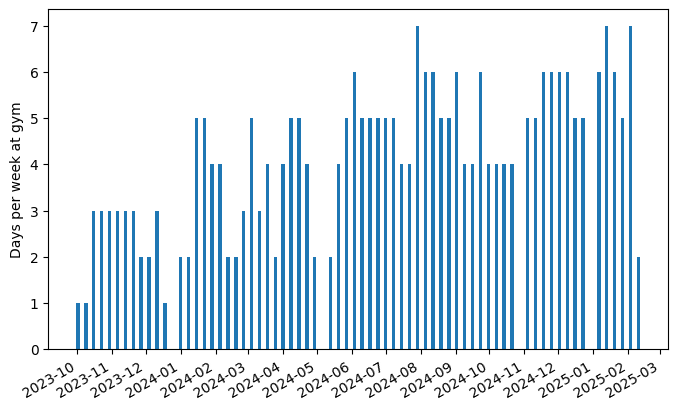

In [7]:
# exercise_bike_results = pd.read_csv(rf'{notes_directory}exercise-bike.csv',header=[0], index_col=[0])
# date_string_list = list(results.keys()) + list(exercise_bike_results.index)
date_string_list = list(results.keys())
datelist = [ datetime.strptime(x, '%Y-%m-%d') for x in date_string_list ]

# remove duplicate date values (caused by exercise bike and lifting on same day)
datelist = list(set(datelist))

calendarresults = [ x.isocalendar() for x in datelist ]
year_and_week_list = [ (x[0], x[1]) for x in calendarresults]

unique_weeks = [ datetime.strptime(f"{x[0]}-{x[1]}-1", "%Y-%W-%w") for x in Counter(year_and_week_list).keys() ]
unique_week_counts = [ x for x in Counter(year_and_week_list).values() ] 
fig, ax = plt.subplots(figsize=(8,5))
plt.bar(unique_weeks,unique_week_counts, width=3)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
ax.set_ylabel('Days per week at gym')
plt.savefig(rf'{results_directory}\figures\days.png', dpi=300, bbox_inches='tight')

# theres an error with this that results in a gap at the end of each year

In [8]:
# set up dataframes for each lift
lift_count_dict = {}
for date in results:
    for lift in results[date]:
        lift_count_dict[lift] = lift_count_dict.get(lift, 0) + 1

lift_count_df = pd.DataFrame.from_dict(lift_count_dict,orient='index',columns=['Days performed'])
# lift_count_df = lift_count_df.sort_values(['Days performed'], ascending=[False])
display(lift_count_df)

lift_df_dict = {}
lift_info_df = pd.DataFrame(columns=['UniCheck','BWCheck'])
for lift, row in lift_count_df.iterrows():
    lift_df_dict[lift],lift_info = liftanalyser(lift)
    lift_info_df = pd.concat([lift_info_df, lift_info], ignore_index=False)

Days performed
Squat                                         82
Pinwheel curl                                 30
Forward facing cable curl                      1
Rope pushdown                                 35
Overhead cable extension                       7
...                                          ...
Smith machine squat                            1
Cable crunch                                   1
EZ bar overhead tricep extension               1
Tricep pushdown                                1
Barbell row                                   15

[122 rows x 1 columns]

In [9]:
def liftplot(lift_name, num_dates=False):

    lift_df = lift_df_dict[lift_name]
    UniCheck = lift_info_df.loc[lift_name, 'UniCheck']
    BWCheck = lift_info_df.loc[lift_name, 'BWCheck']

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    if num_dates > 0:
        lift_df = lift_df[0:num_dates]

    x = lift_df.index

    style = "+-"

    if BWCheck:
        y = lift_df['Reps']
        plt.plot(x,y,style)
        legend_names = ["Max reps"]

    else:
        y1 = lift_df['Weight'].values
        plt.plot(x,y1,style)
        
        y2 = lift_df['Borm'].values

        if UniCheck:
            for i in range(len(y2[0])):
                plt.plot(x,[pt[i] for pt in y2],style)
            legend_names = ["Max weight","Left BORM","Right BORM"]
        else: 
            plt.plot(x,y2,style)
            legend_names = ['Max weight', 'BORM']

    # make dates angled
    plt.gcf().autofmt_xdate()

    plt.title(lift_name)
    plt.legend(legend_names)
    # add horizontal lines
    plt.grid(axis = 'y')
    
    # this is all to set the x ticks to intervals of weeks
    x_range = (max(x) - min(x)).days
    max_ticks = 12  # the most ticks that can appear on the x-axis
    min_interval = 7  # a week (7 days) is the minimum distance between two ticks
    if num_dates > 0: min_interval = 1
    interval = max( int(np.ceil(x_range/(max_ticks*min_interval))*min_interval), min_interval)
    tick_count = int(np.floor(x_range/interval))
    ax=plt.gca()
    ax.set_xticks([min(x) + dt.timedelta(days=i*interval) for i in range(tick_count+1)])

    plotname = lift_name + ".png"
    plt.savefig(rf"{results_directory}\lift_figures\{plotname}", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

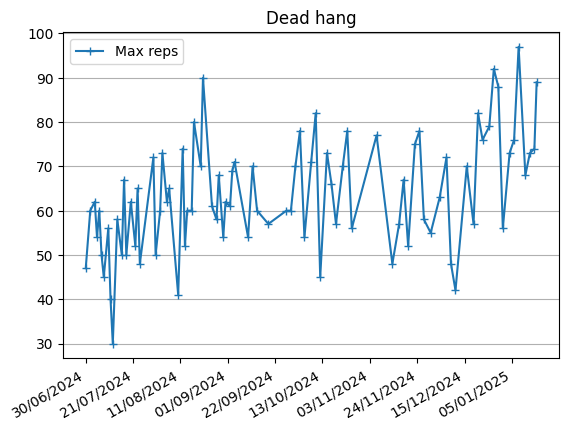

Dead hang, reps and time correlation: 0.4609


In [10]:
# find correlation with time
lift = 'Dead hang'
liftplot(lift)

reps_corr = lift_df_dict[lift]['Reps']
time_corr = lift_df_dict[lift].index.to_series().astype('int64')/ 10**9

print(f"{lift}, reps and time correlation: {time_corr.corr(reps_corr):.4f}")

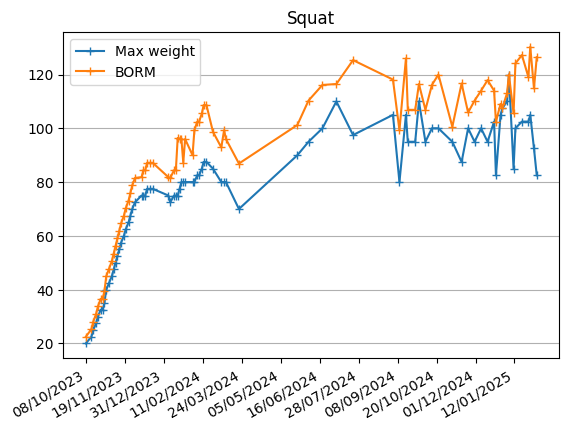

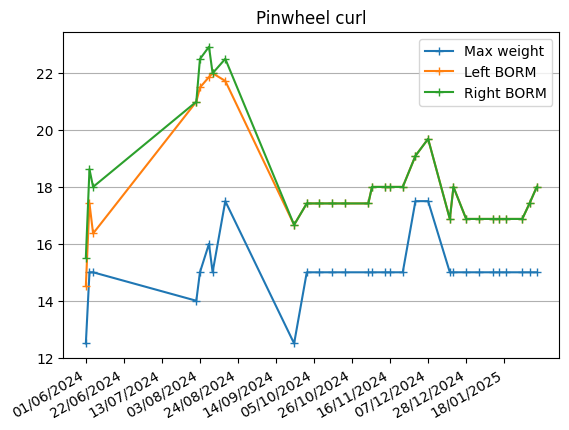

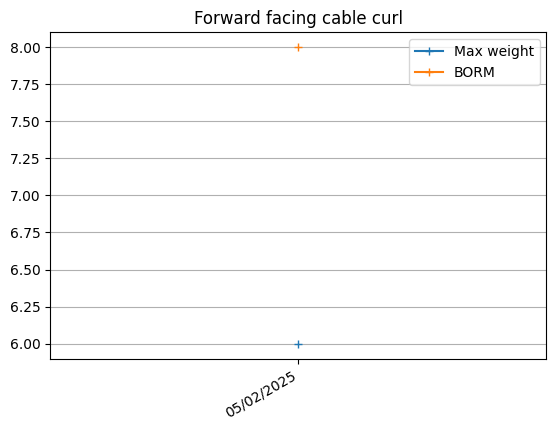

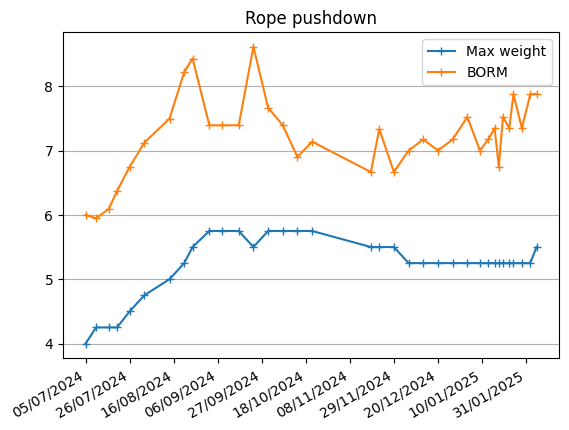

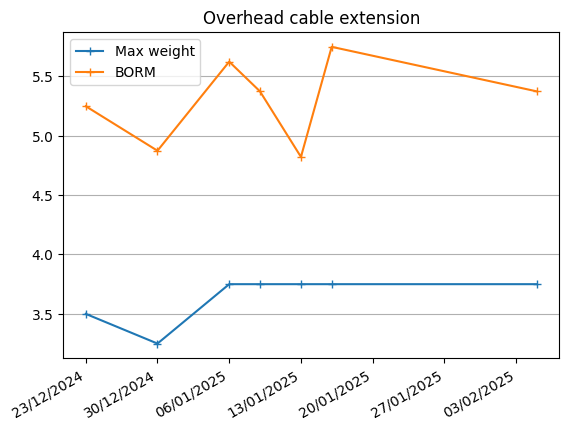

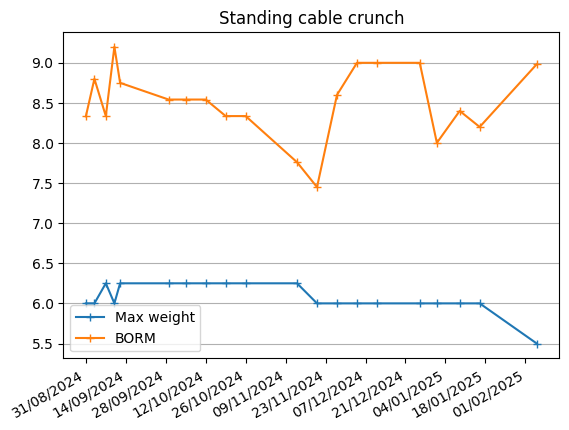

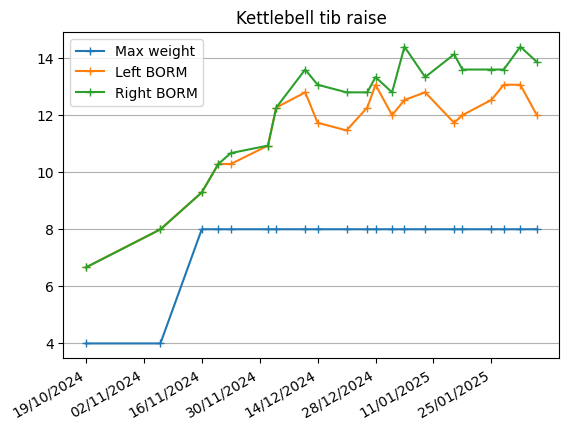

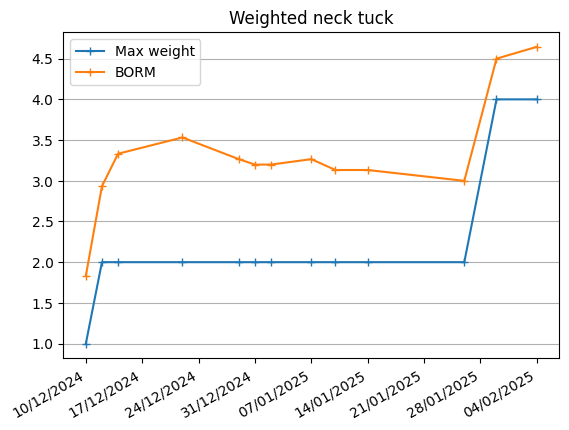

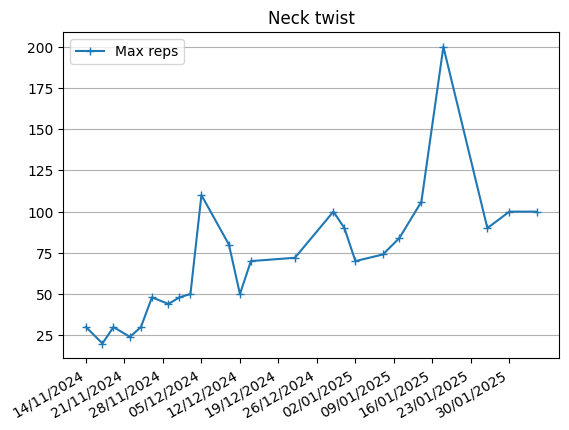

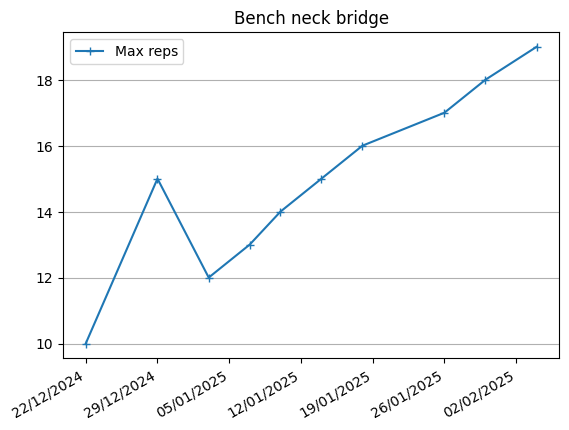

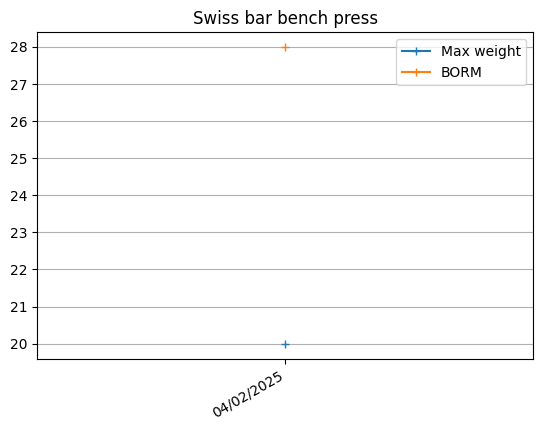

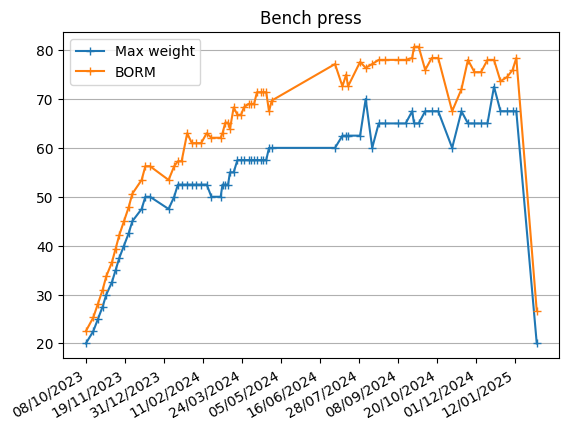

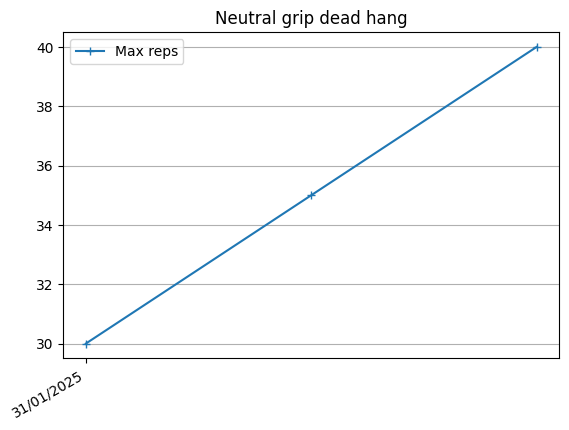

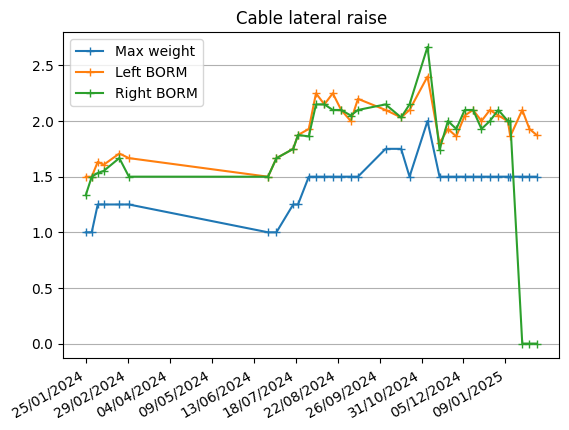

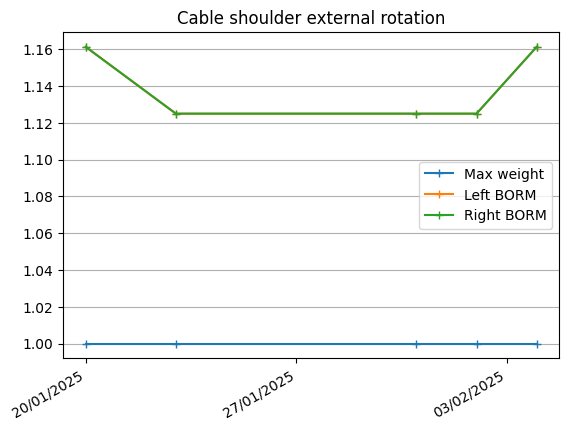

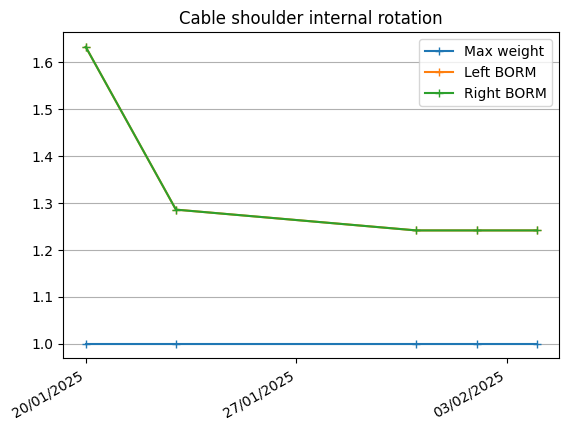

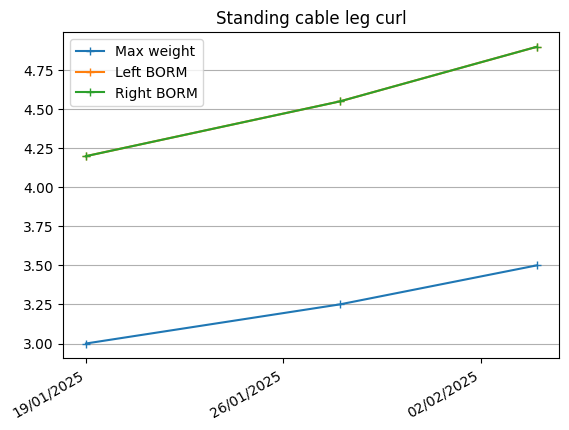

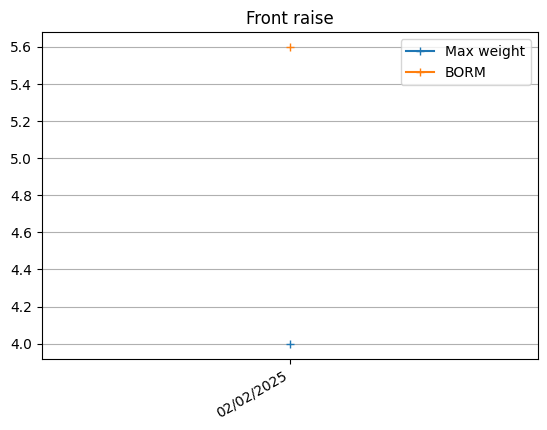

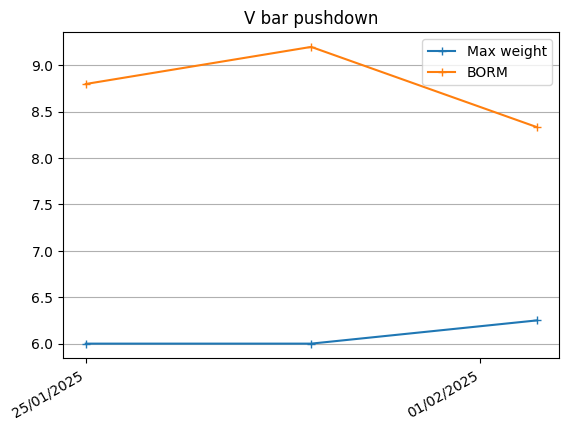

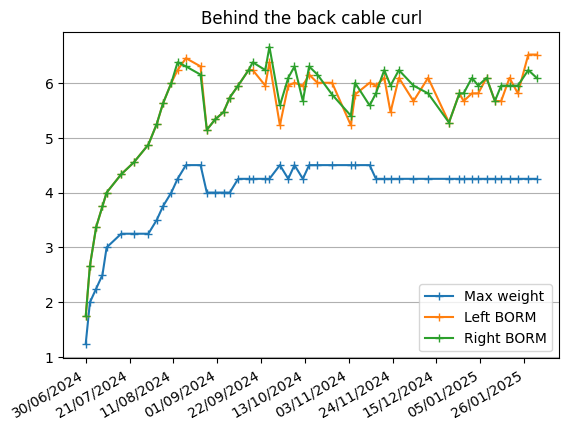

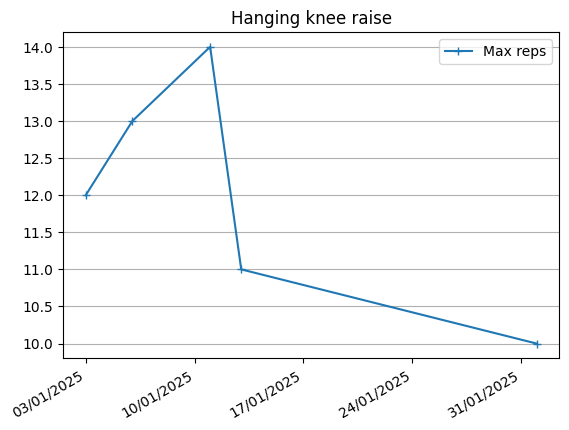

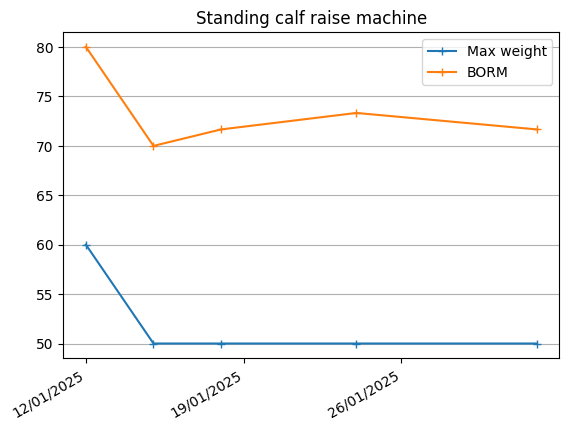

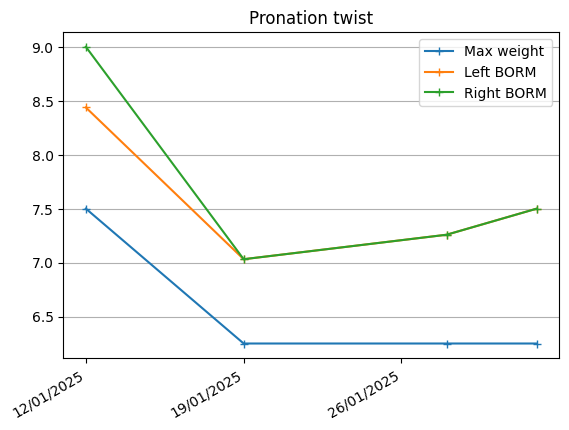

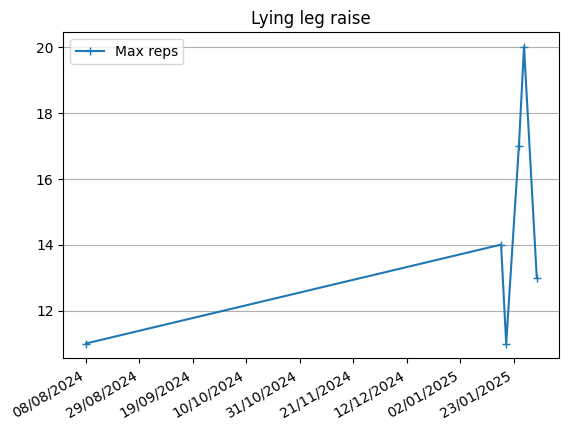

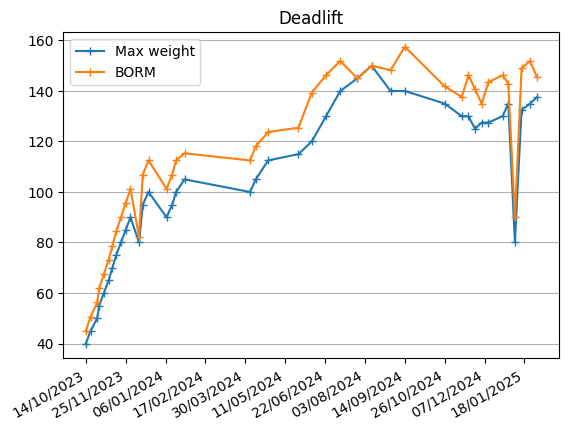

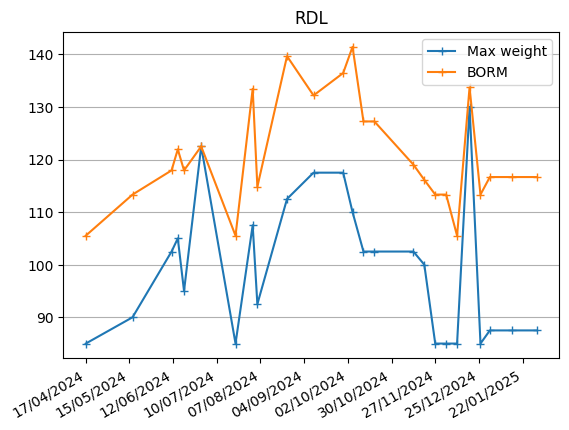

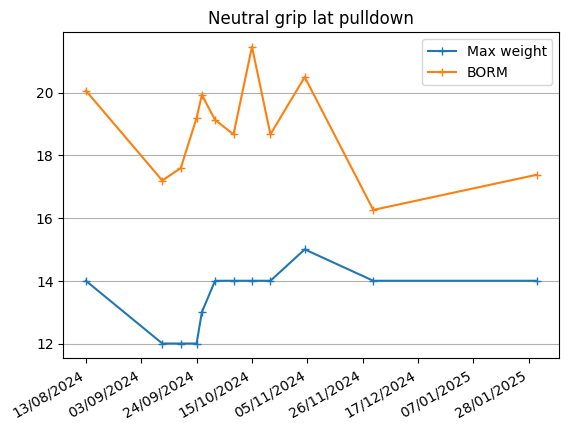

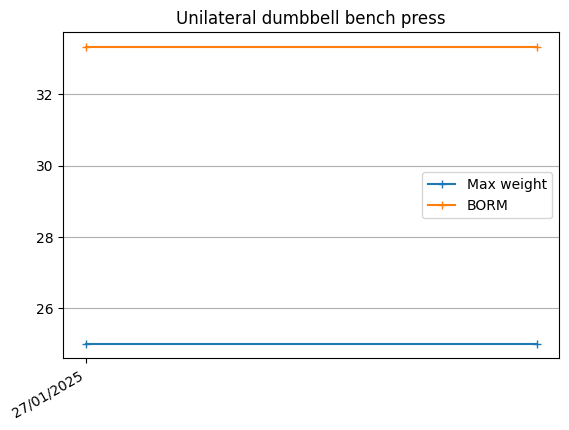

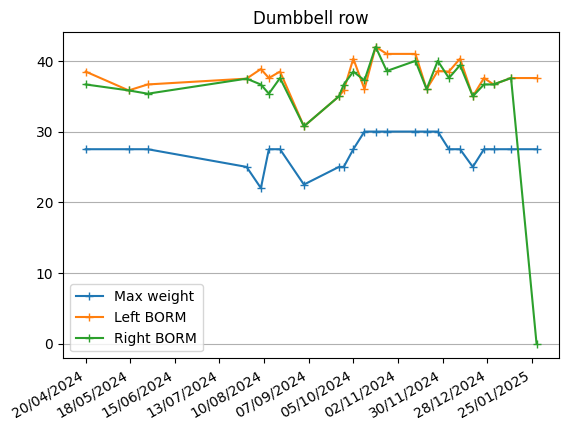

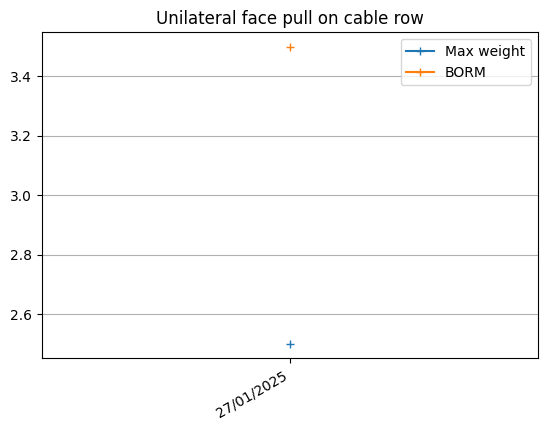

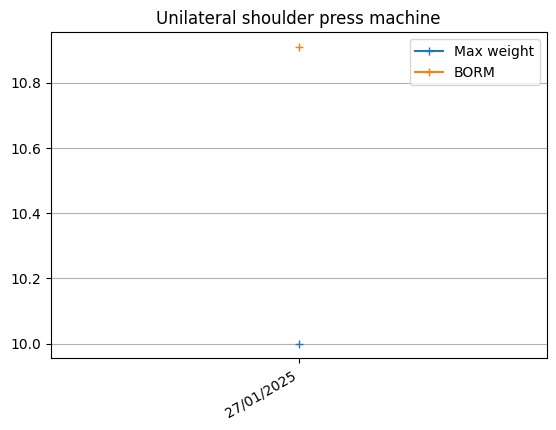

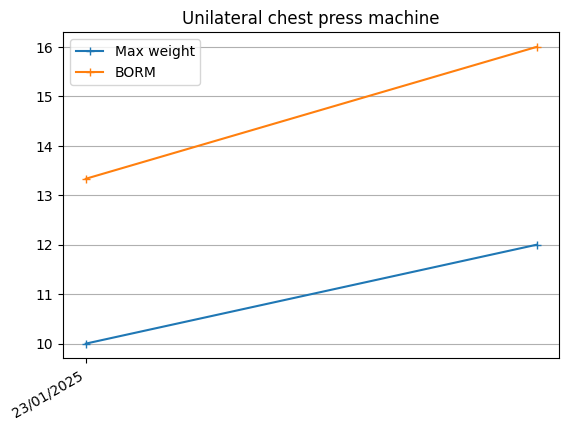

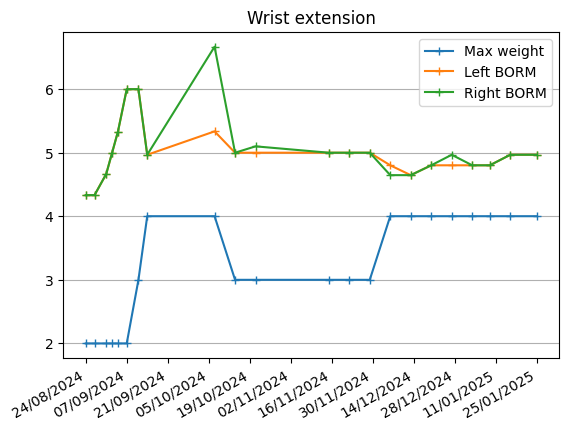

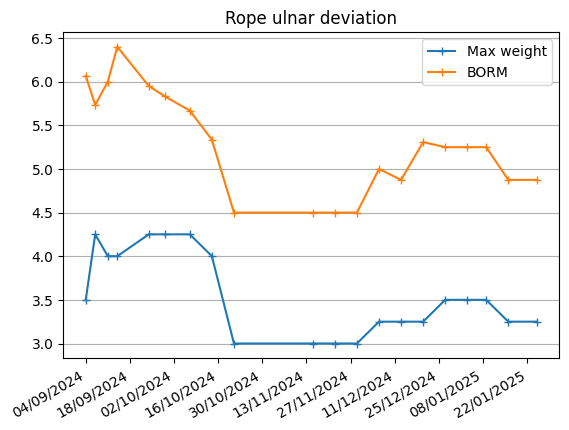

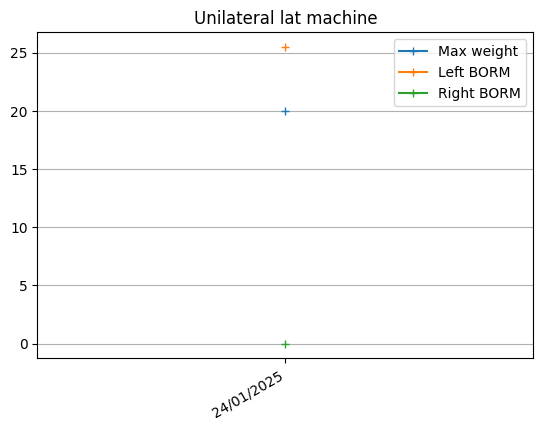

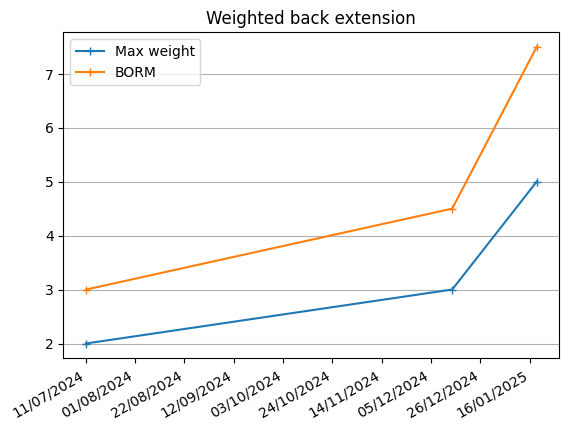

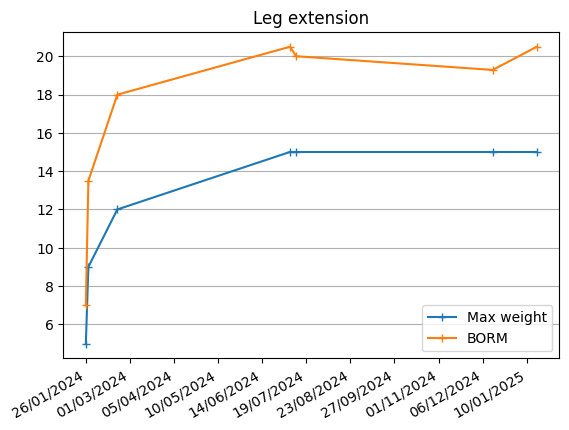

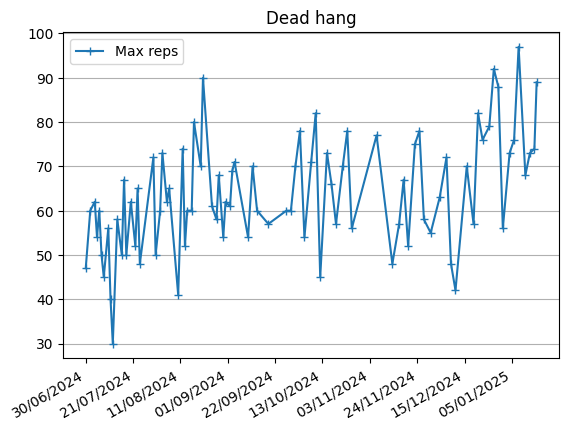

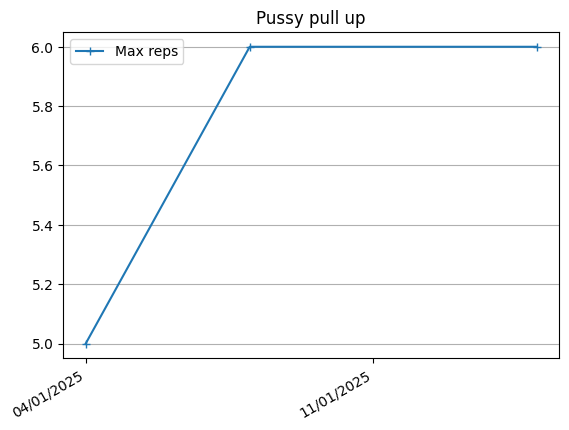

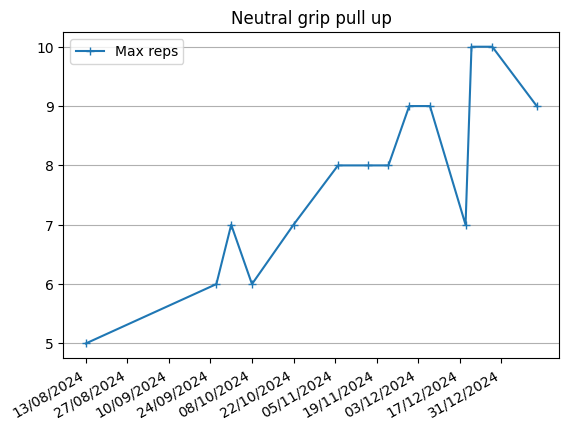

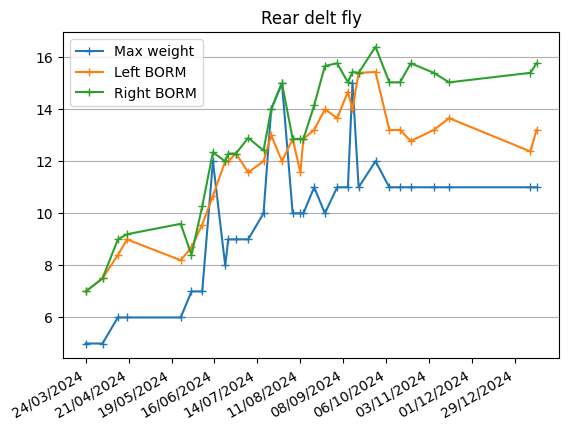

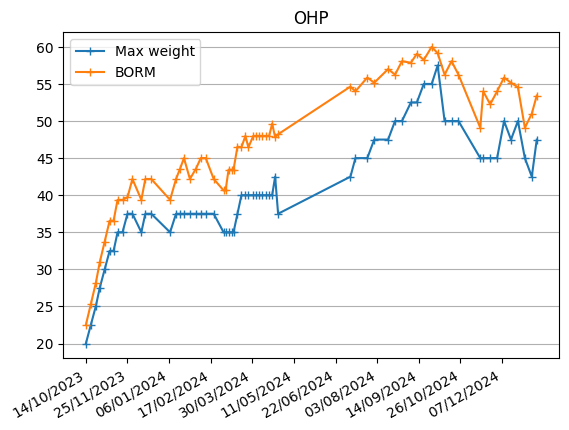

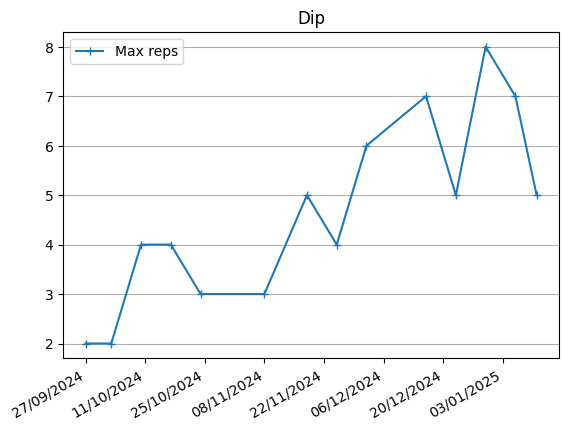

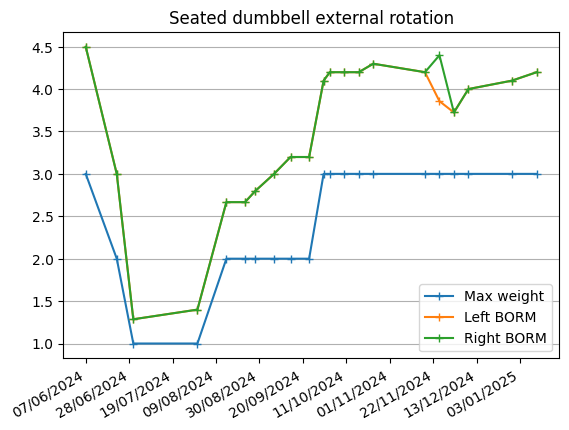

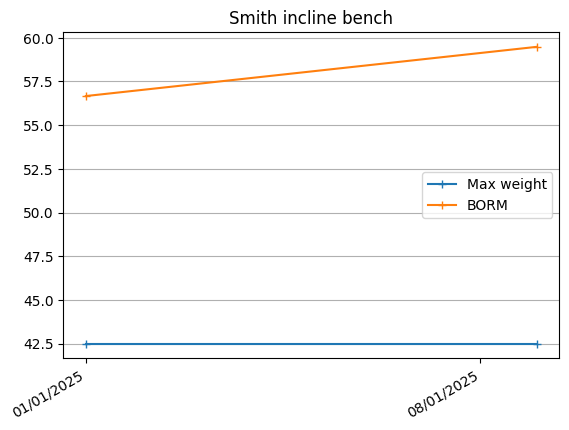

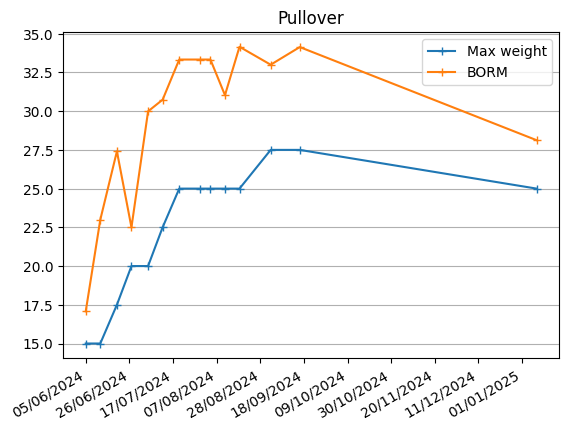

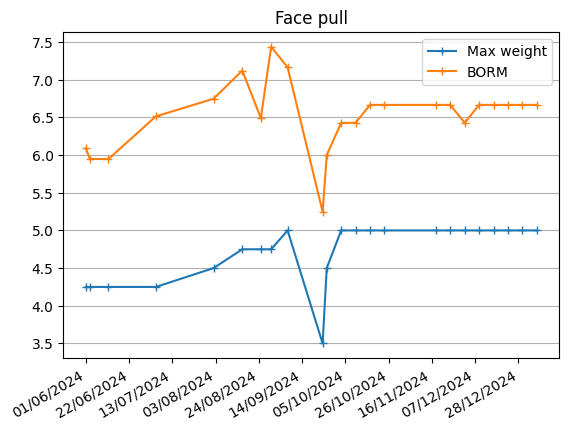

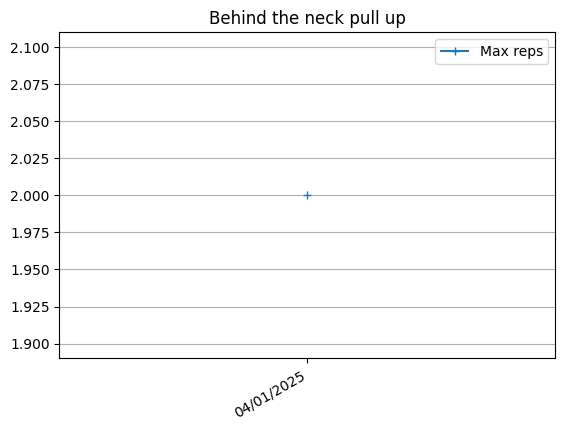

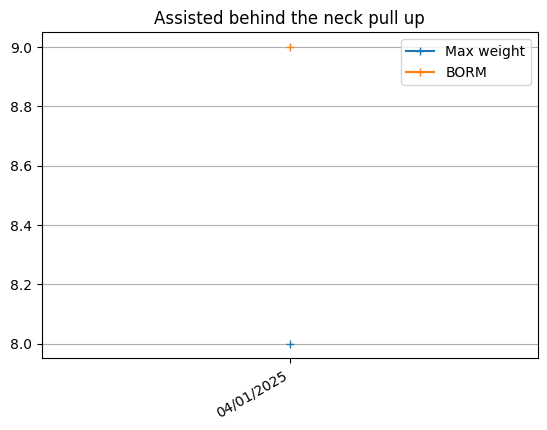

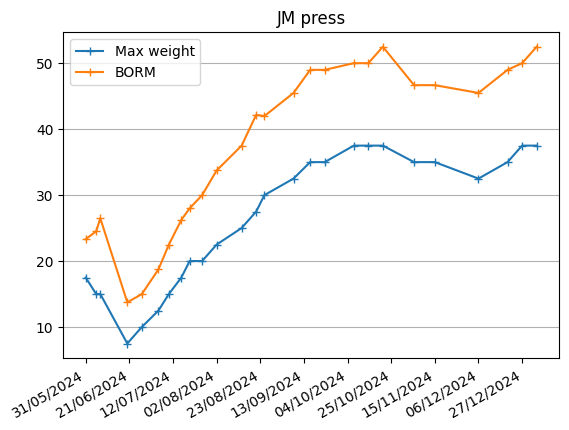

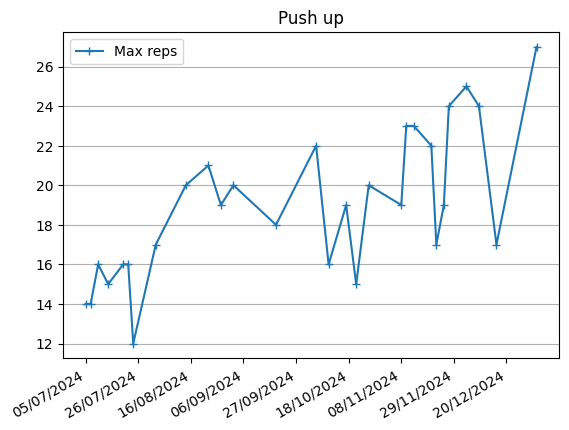

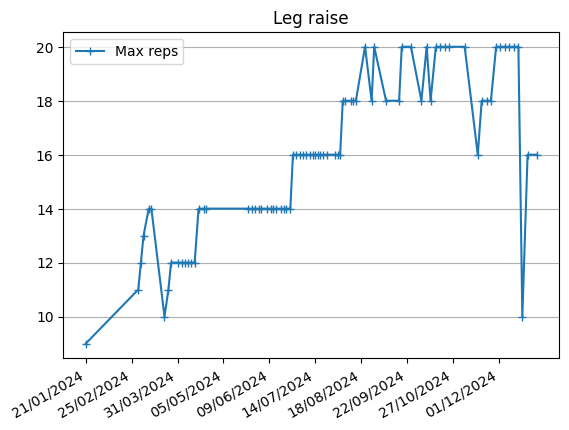

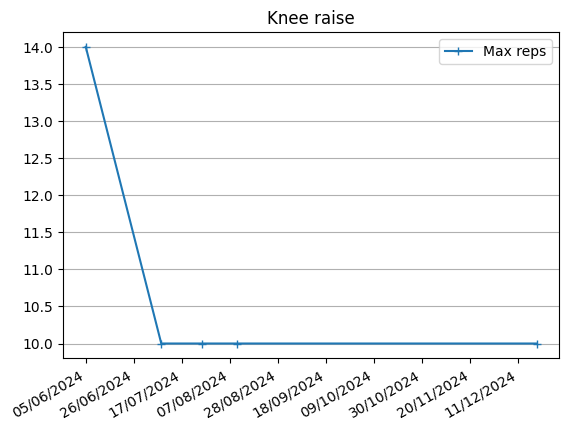

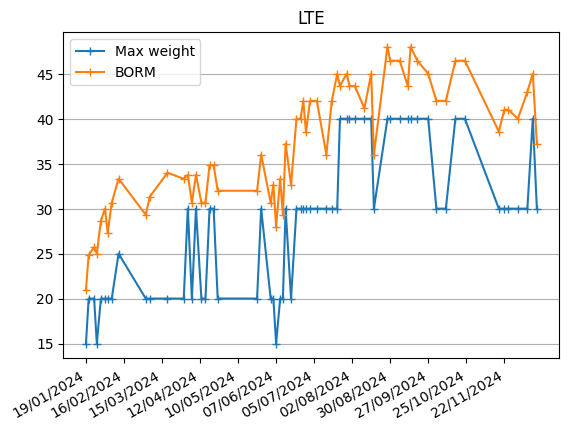

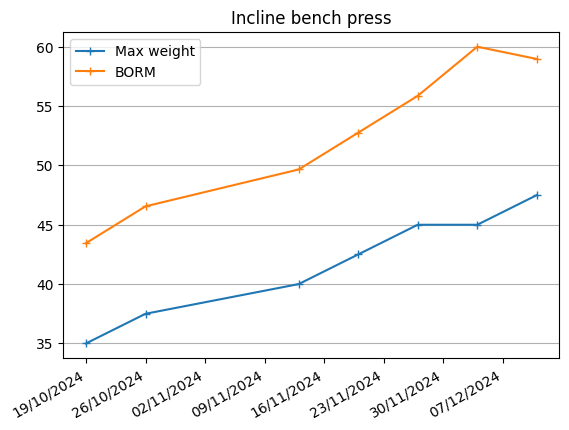

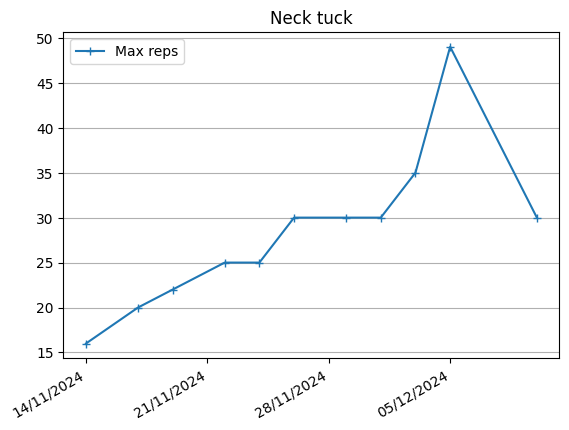

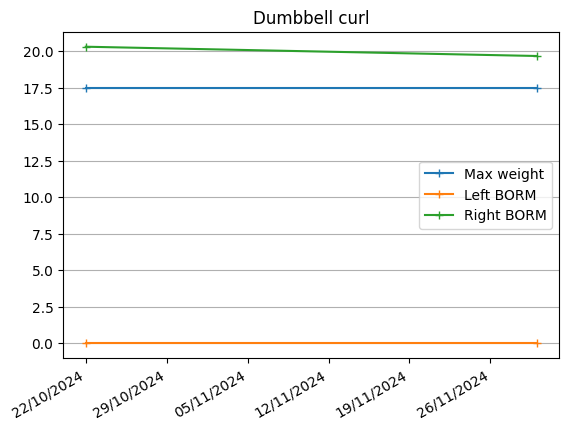

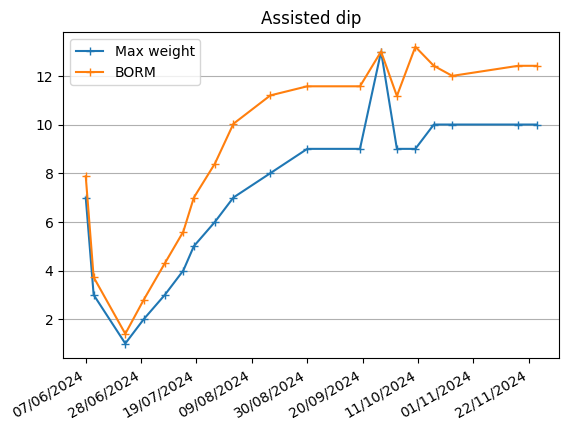

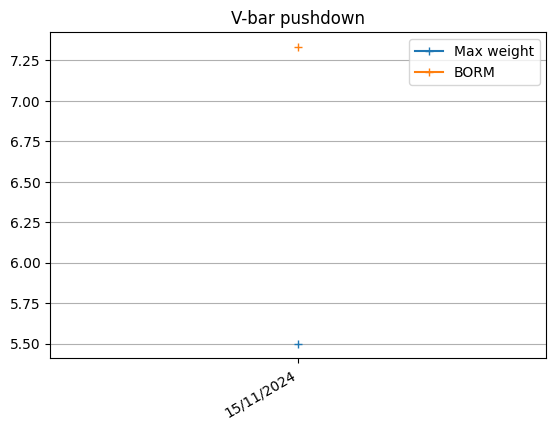

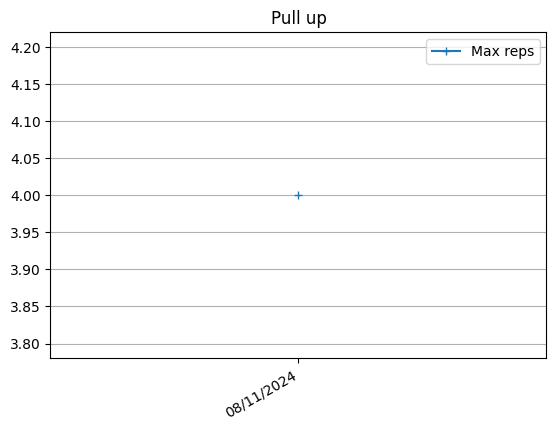

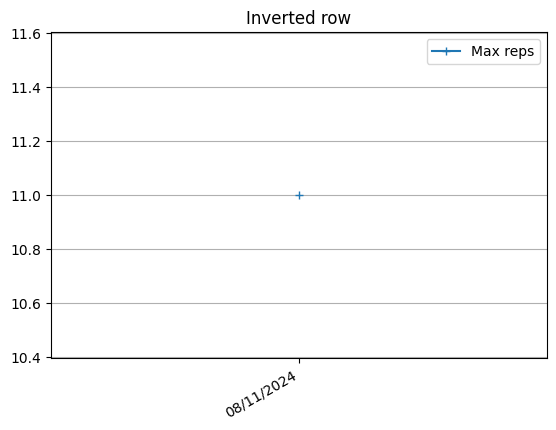

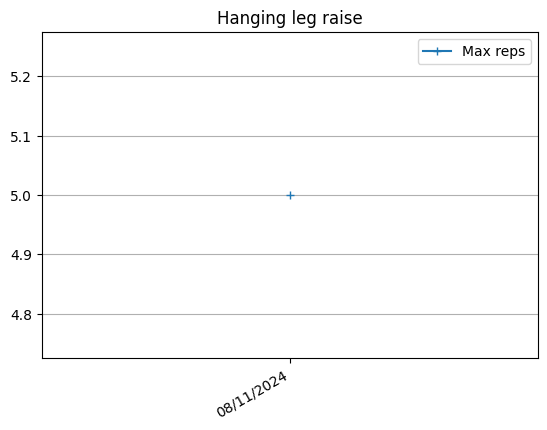

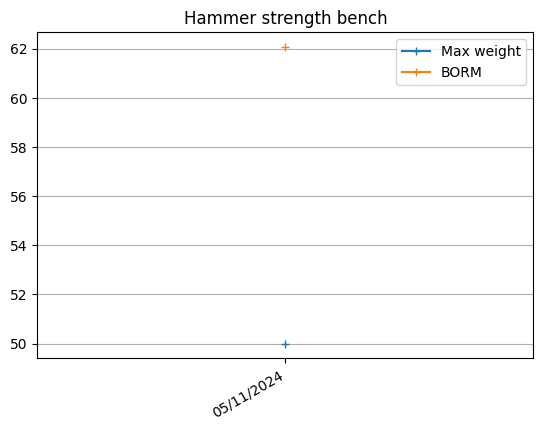

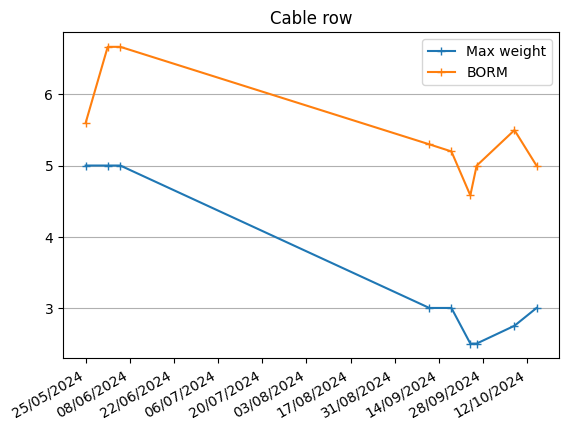

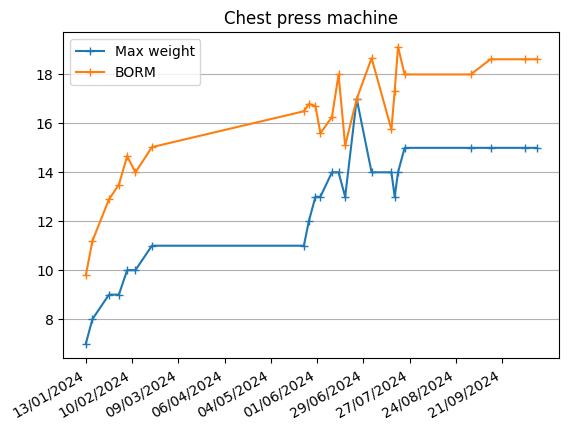

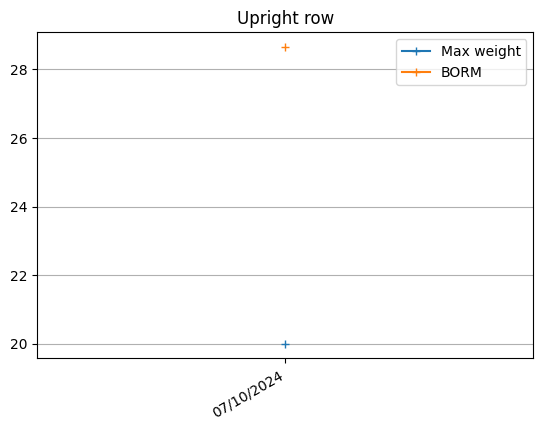

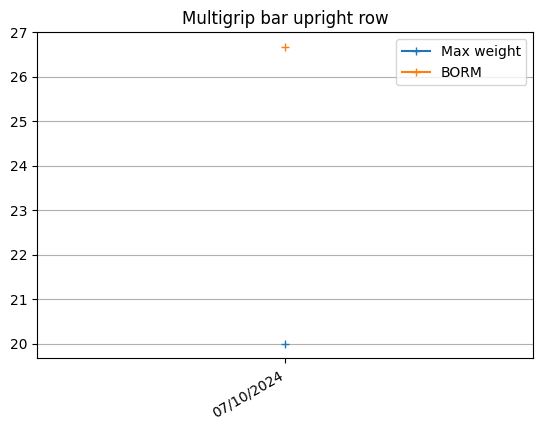

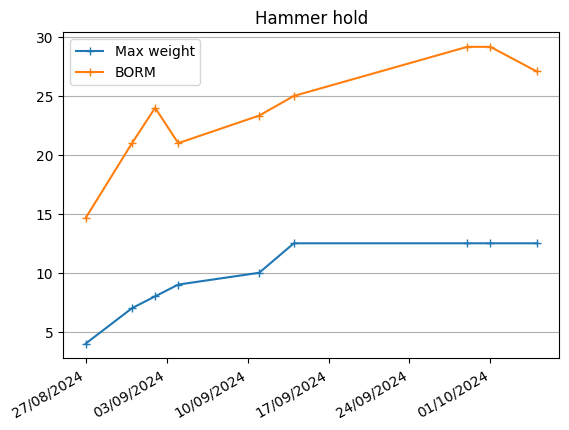

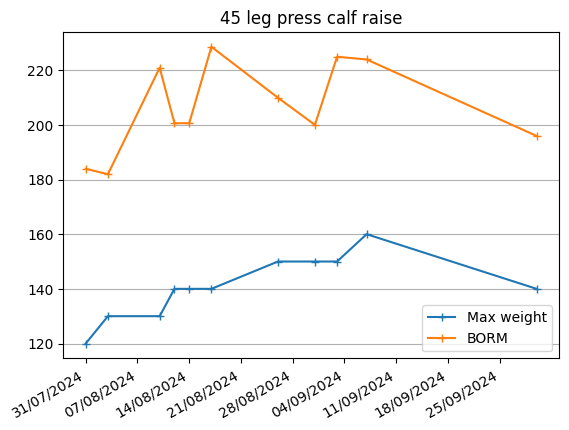

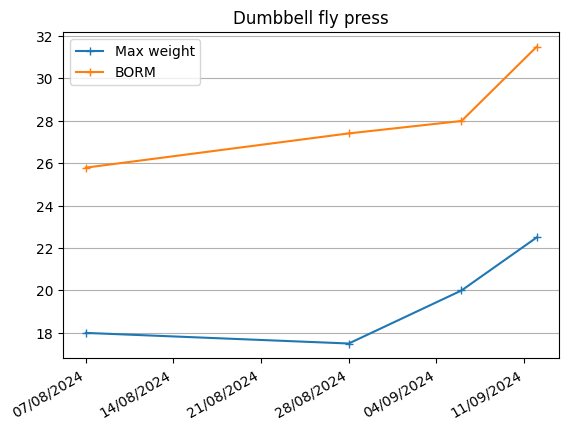

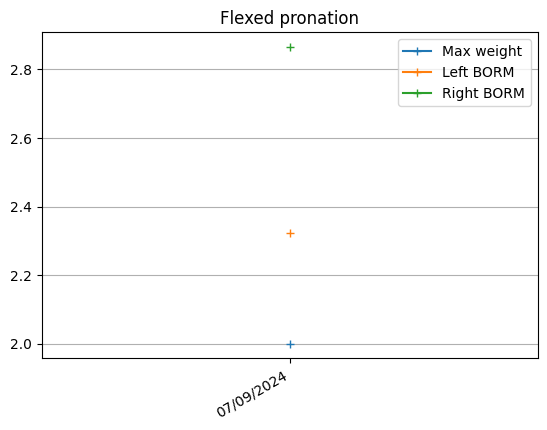

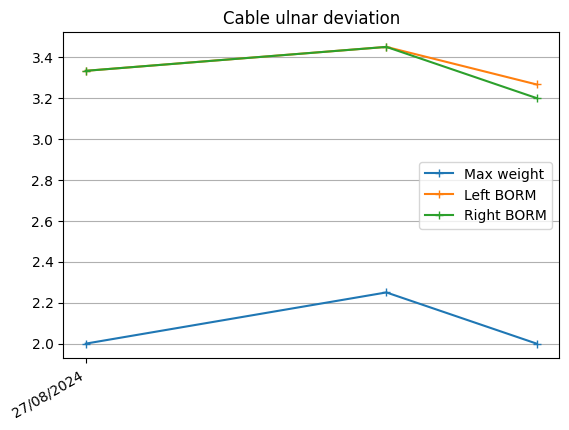

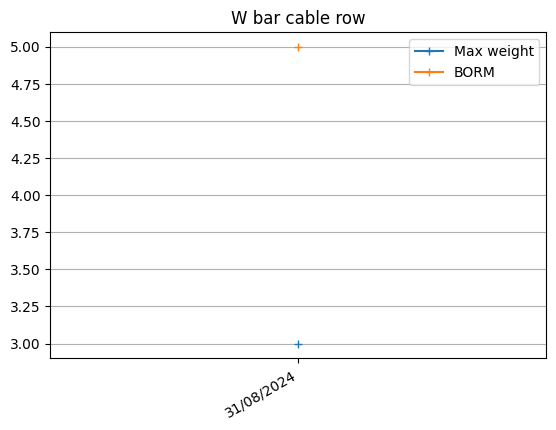

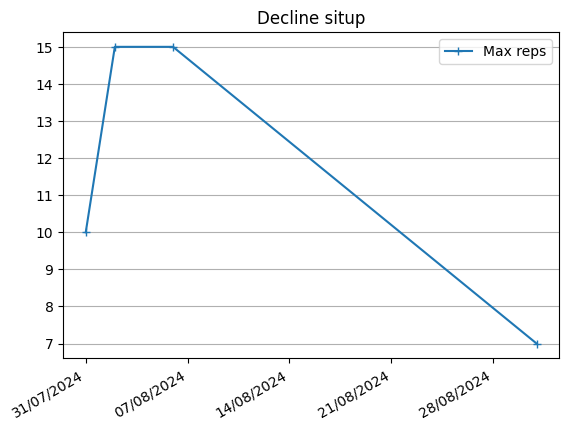

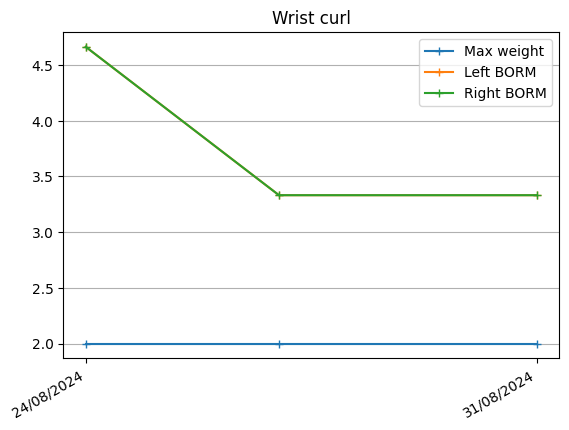

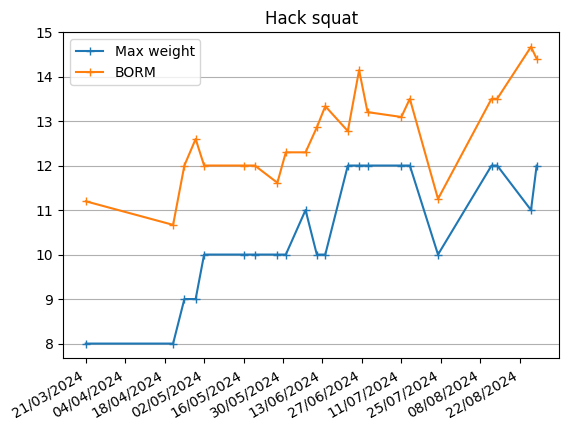

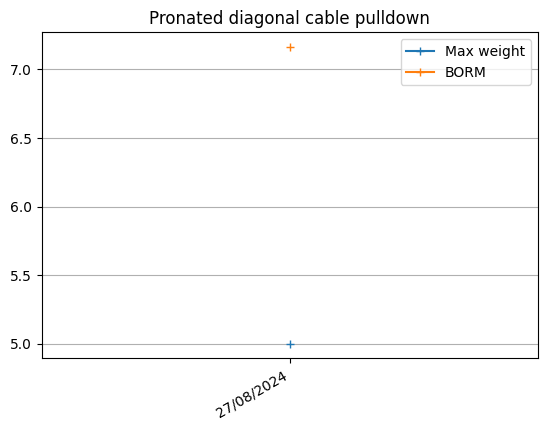

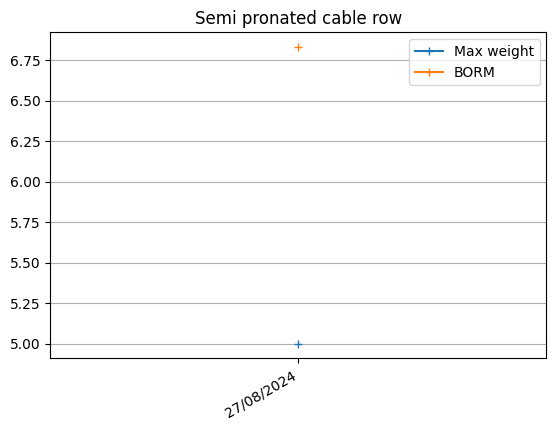

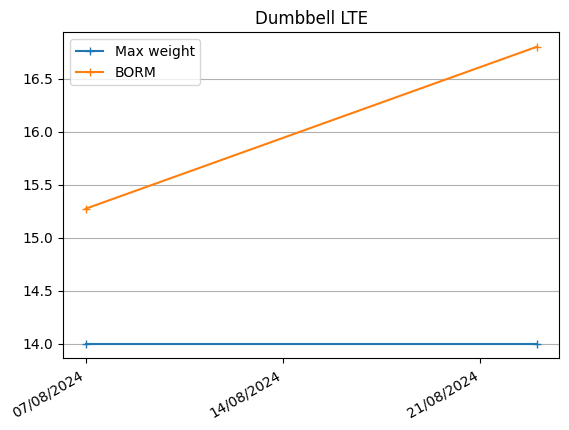

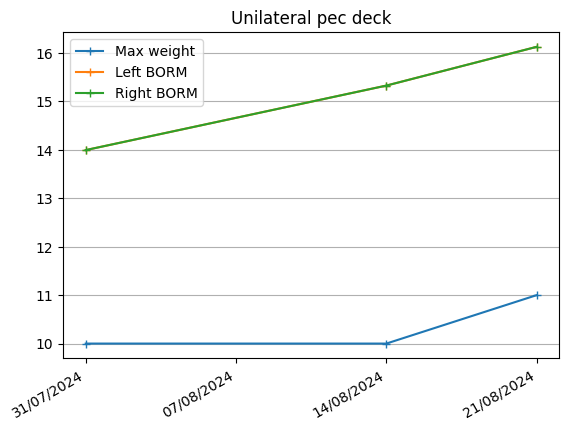

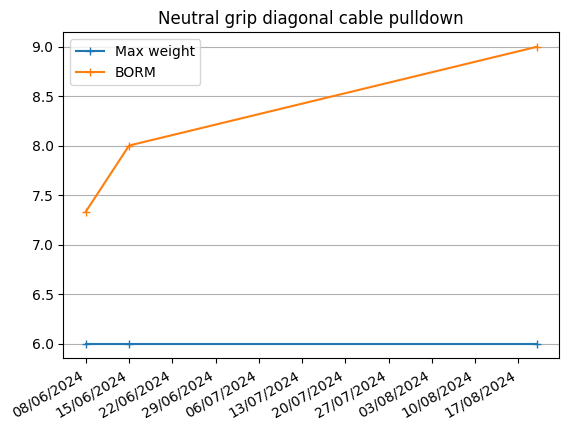

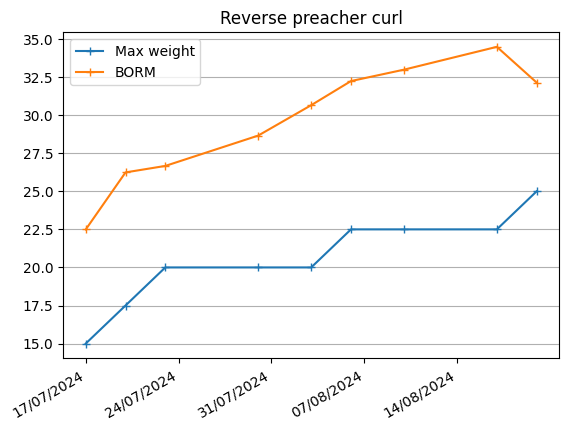

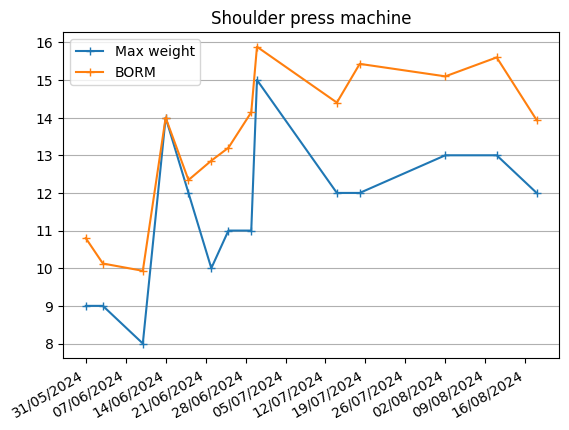

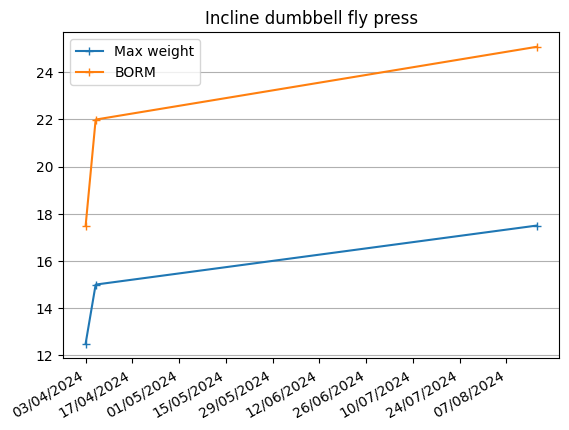

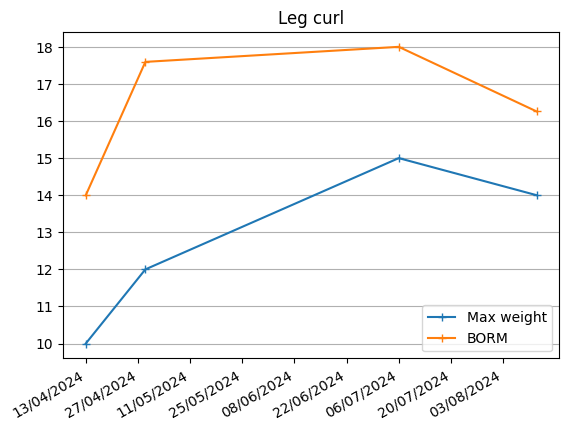

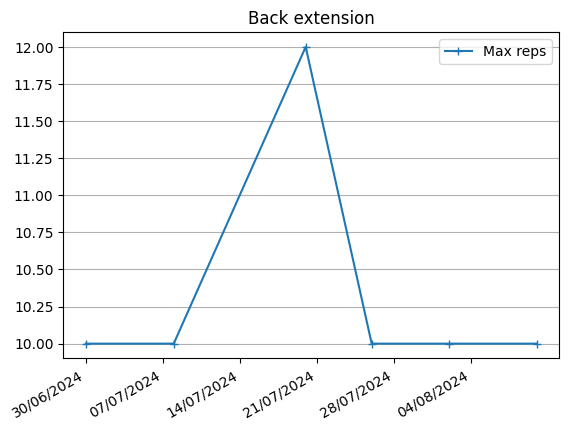

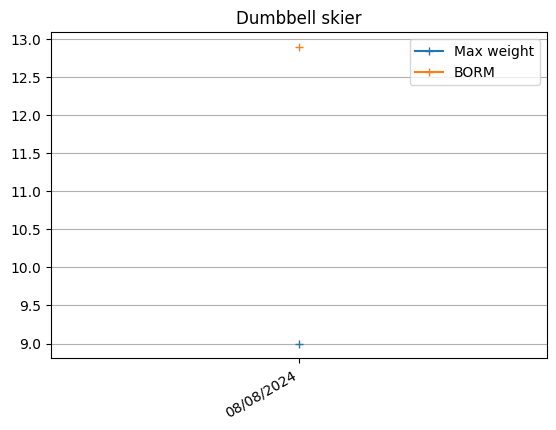

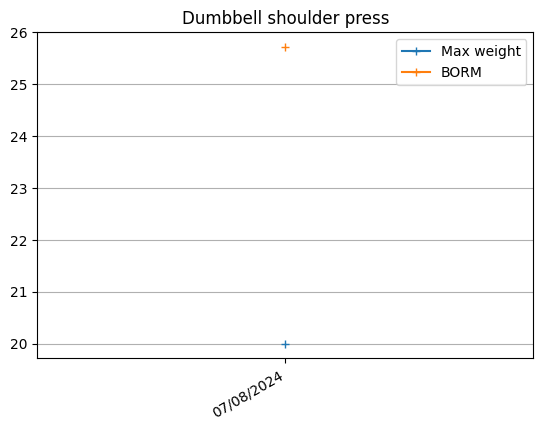

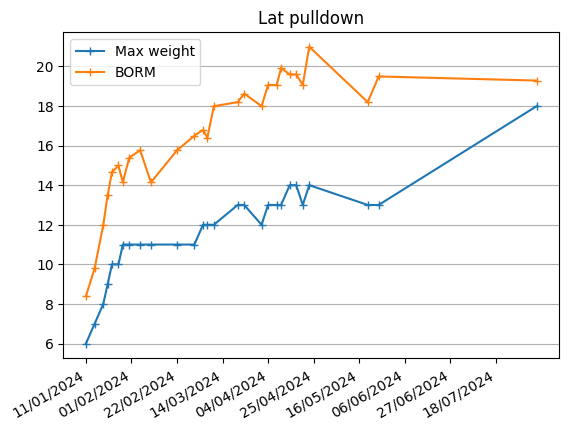

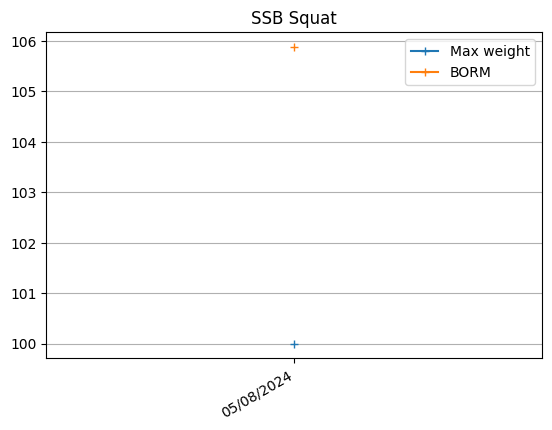

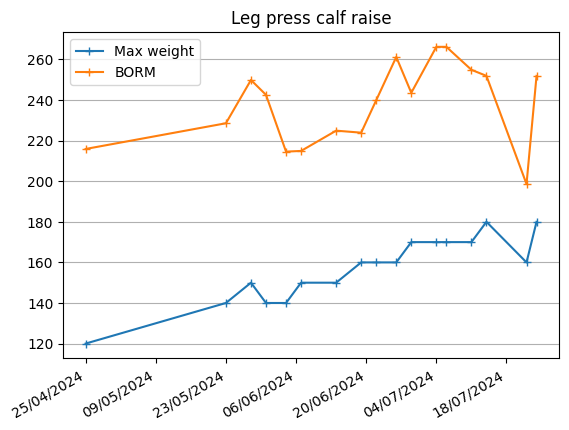

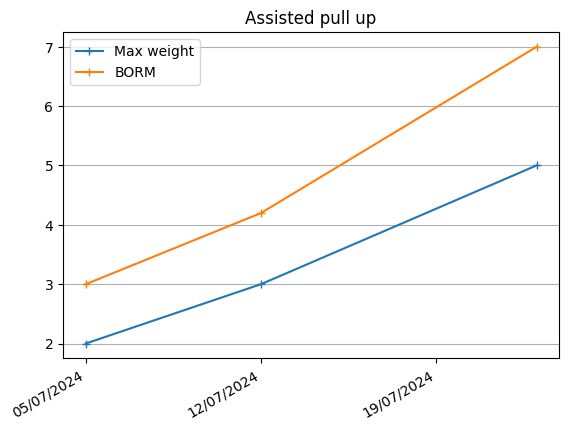

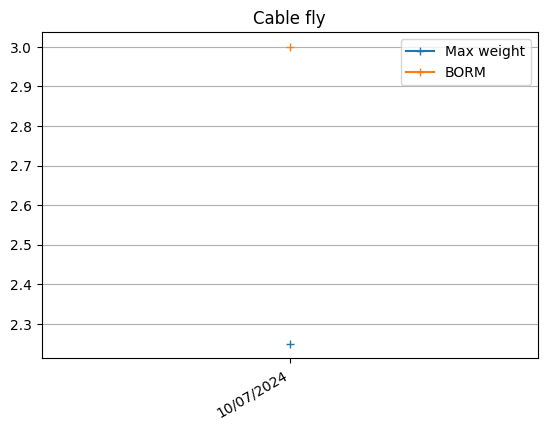

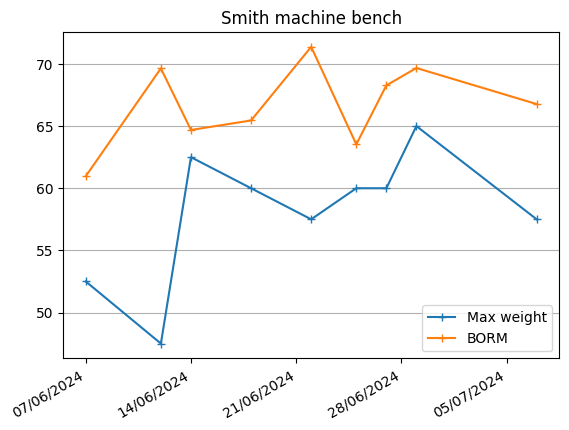

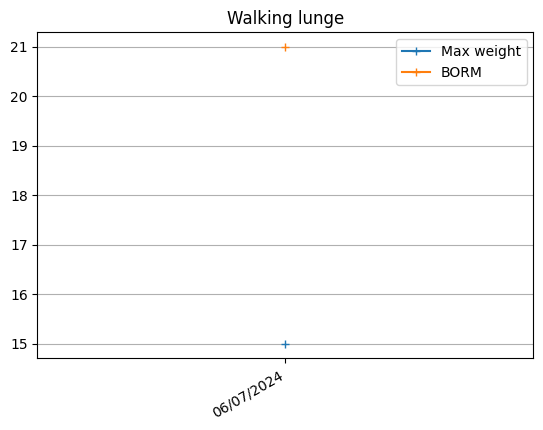

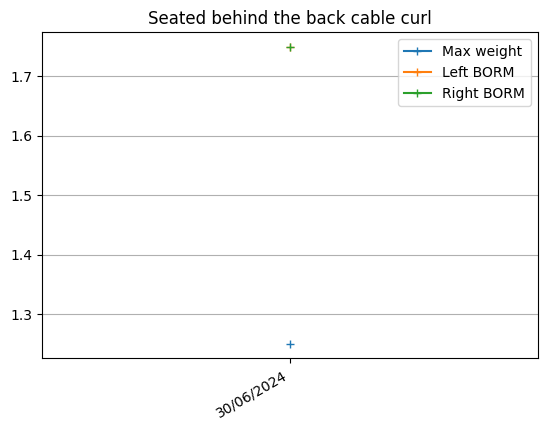

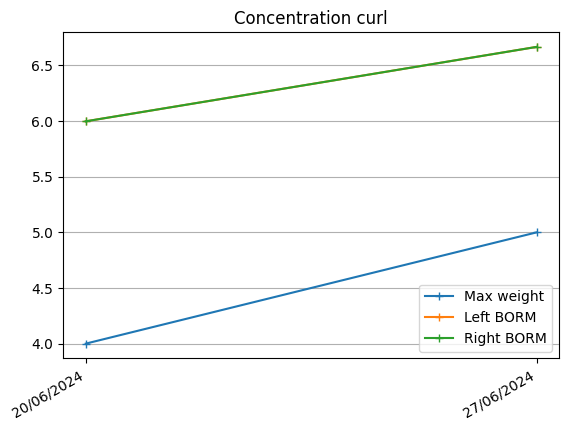

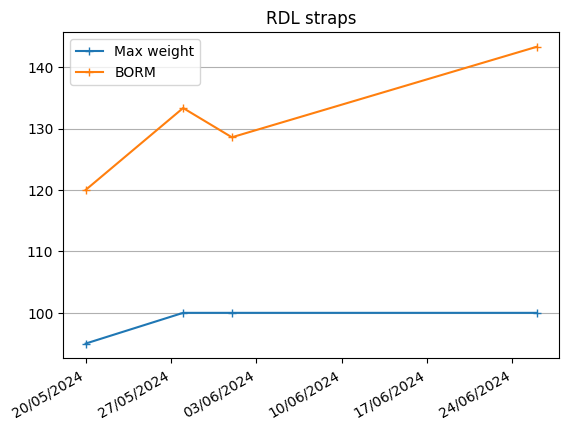

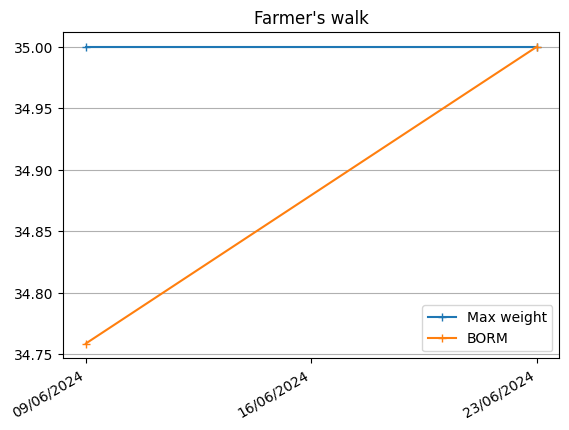

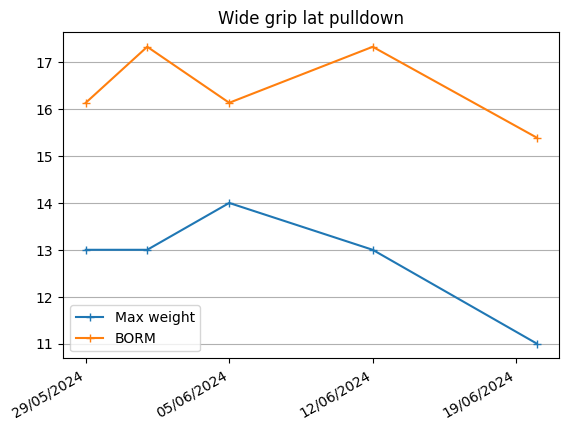

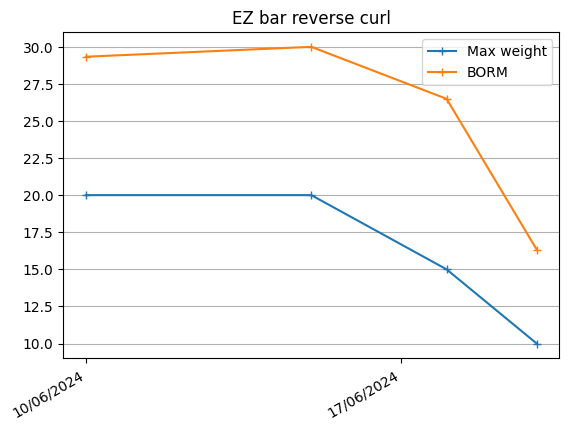

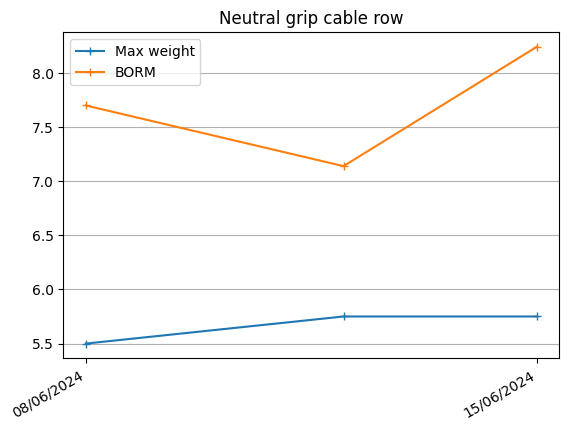

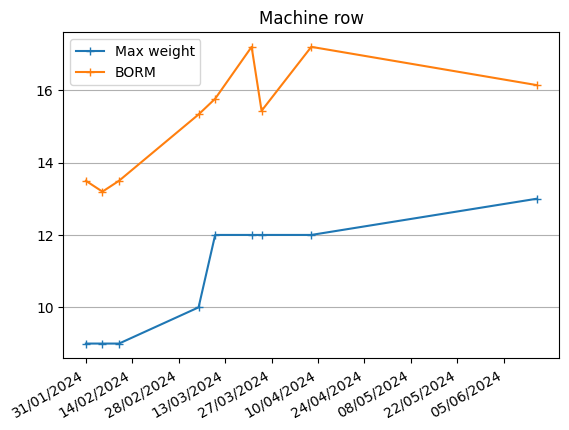

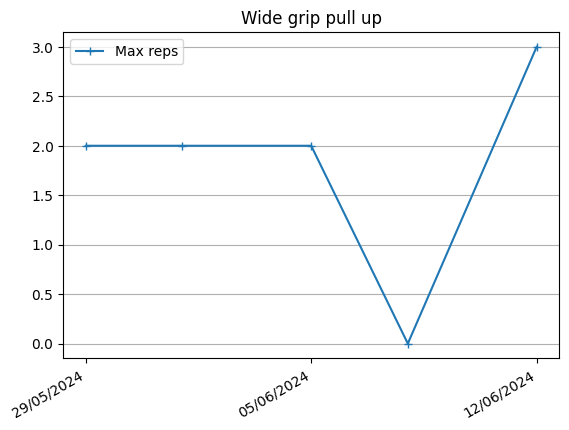

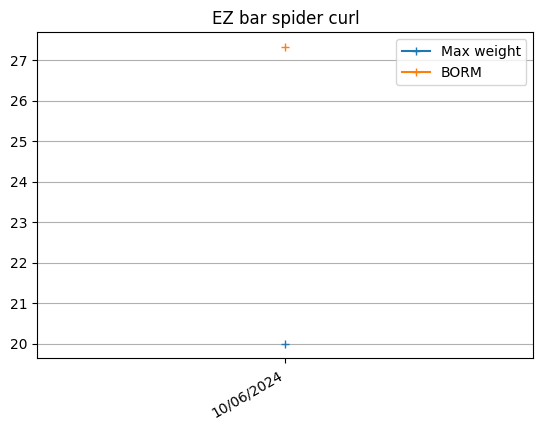

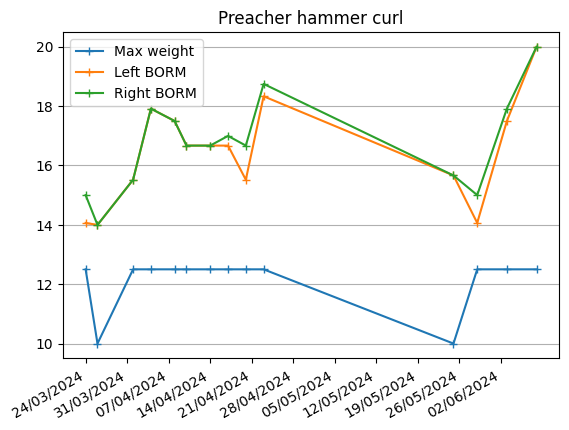

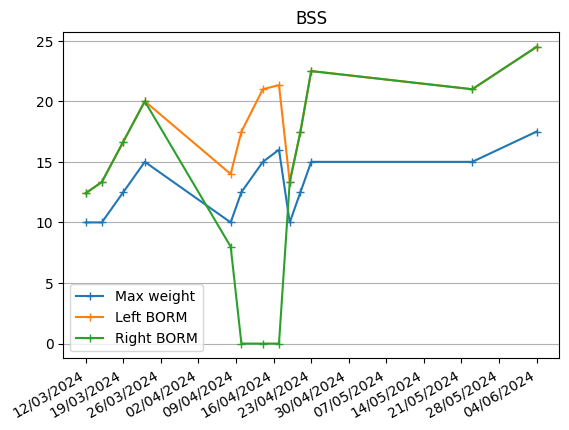

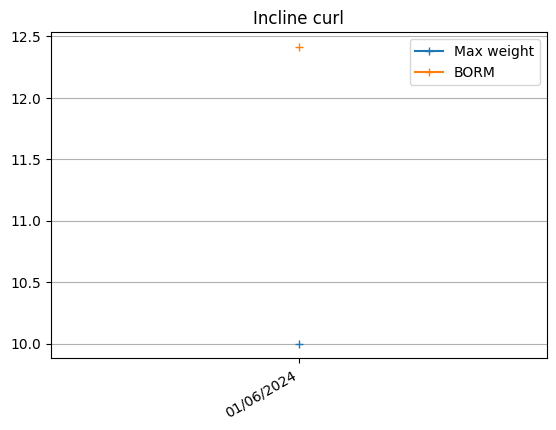

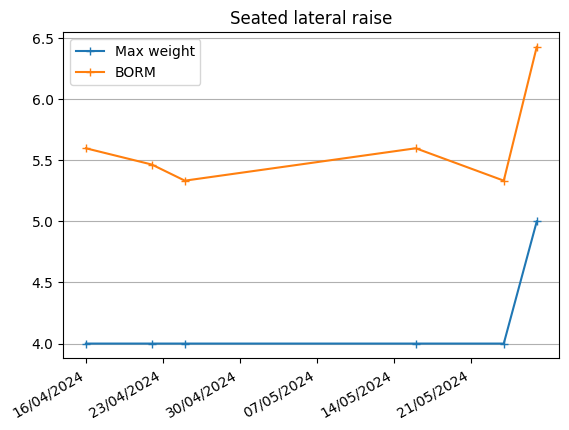

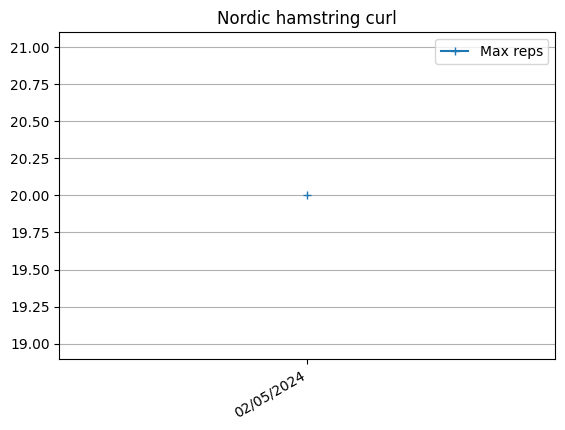

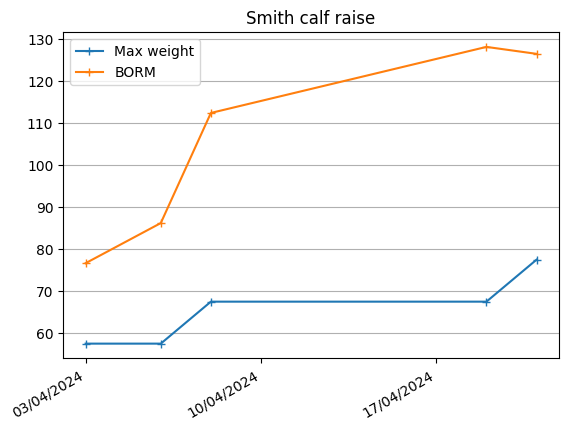

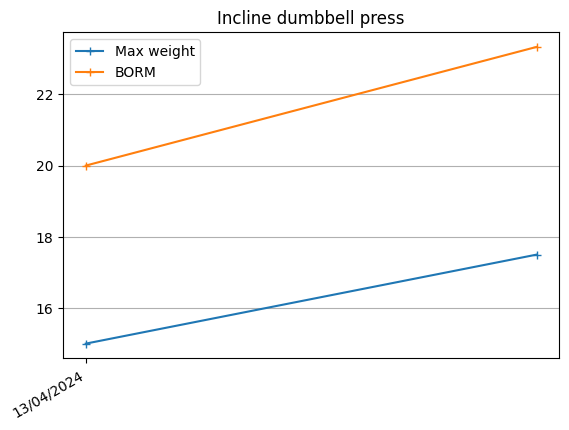

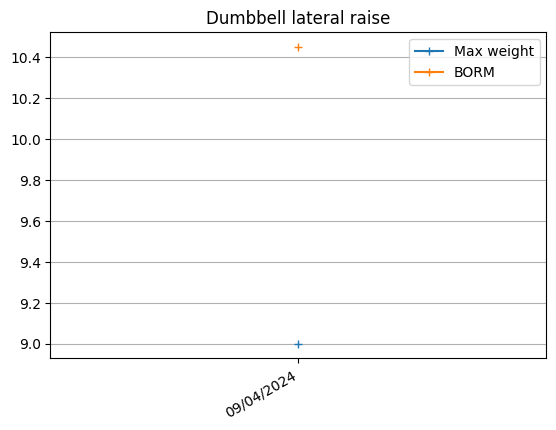

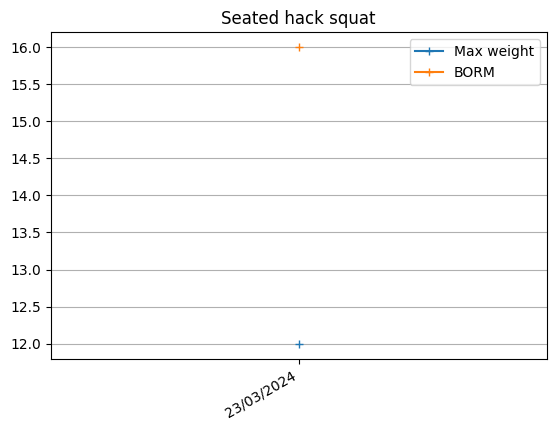

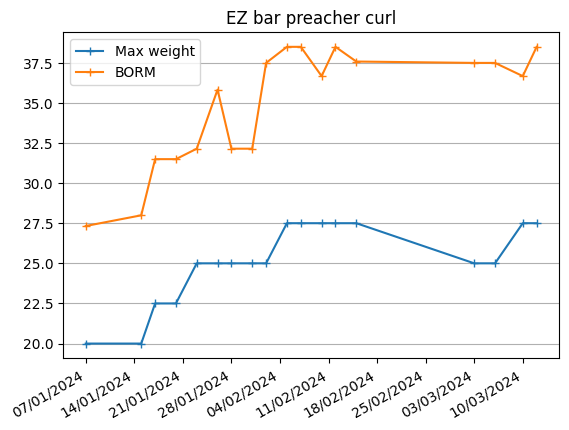

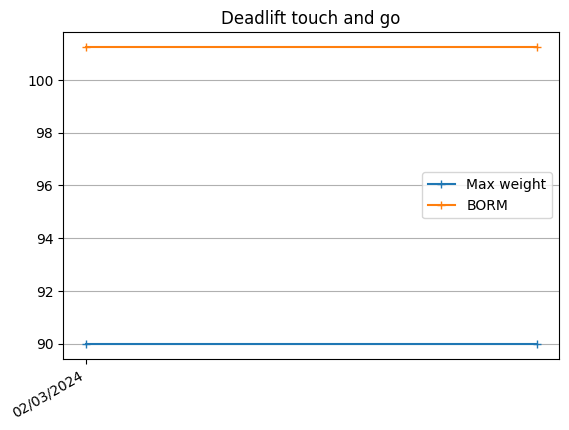

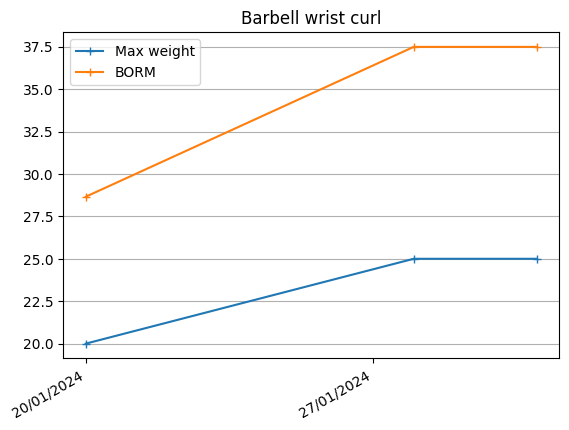

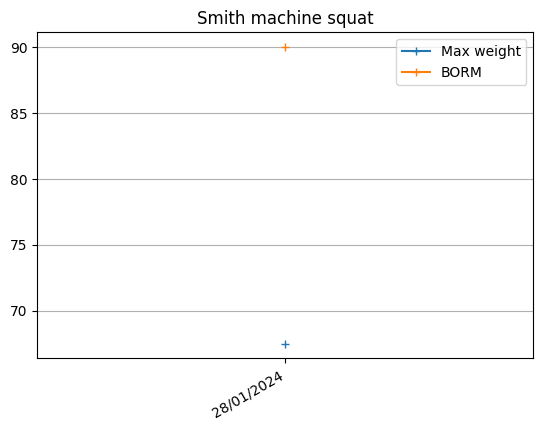

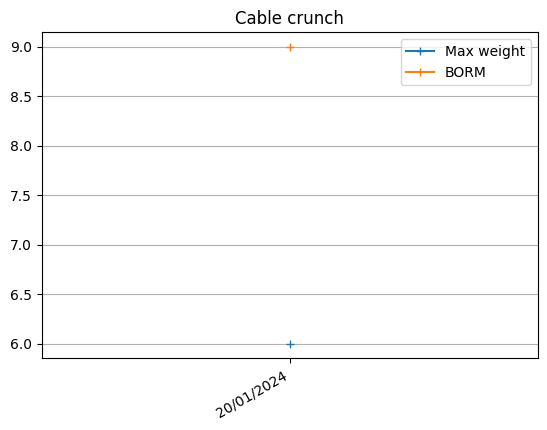

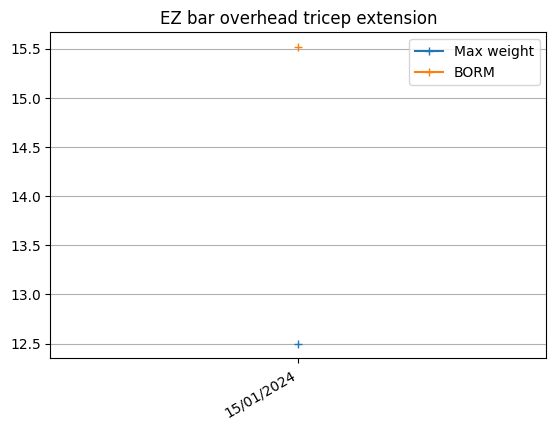

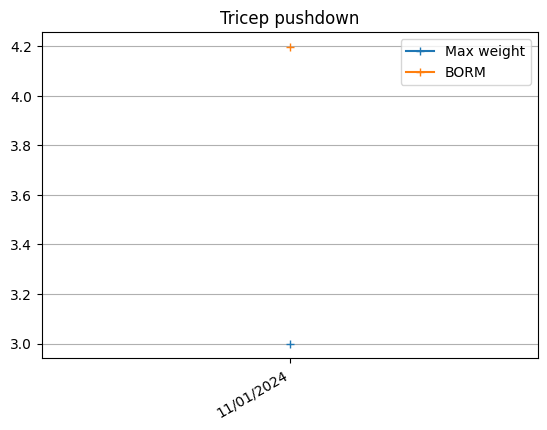

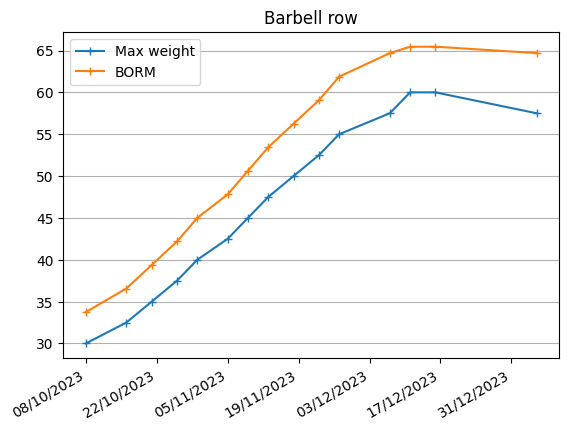

In [11]:
for lift, row in lift_count_df.iterrows():
    liftplot(lift)

In [12]:
current_path = os.path.abspath("")
directory = os.path.dirname(current_path)
weight_md_path = rf"{directory}\Notes\Fitness\Body weight.md" 
weight_df = pd.read_csv(weight_md_path, sep=",", header=None)
weight_df[0] = pd.to_datetime(weight_df[0], format="%Y-%m-%d")
weight_df[1] = pd.to_numeric(weight_df[1], errors='coerce')
weight_df

0     1
0   2025-02-06  82.4
1   2025-02-05  82.5
2   2025-02-04  81.9
3   2025-02-03  82.4
4   2025-02-02  82.1
..         ...   ...
174 2021-04-13  73.5
175 2021-04-06  74.0
176 2021-04-02  75.9
177 2021-03-25  76.9
178 2021-02-25  79.8

[179 rows x 2 columns]

In [13]:
def weight_at_date(date,weight_df):
    if date in weight_df[0]:
        bw = weight_df[1].values[date]
    else:
        earlier_dates = weight_df[0][weight_df[0] < date]
        later_dates = weight_df[0][weight_df[0] > date]
        nearest_earlier_date = max(earlier_dates)
        # check if latest lift is more recent than latest weight measurement
        # in which case, body weight is simply equal to last recorded weight
        if len(later_dates) == 0:
            earlier_row = weight_df.index.get_loc(weight_df[weight_df[0] == nearest_earlier_date].index[0])
            bw = weight_df.iloc[earlier_row,1]
        # if not, interpolate
        else:
            nearest_later_date = min(later_dates)

            earlier_row = weight_df.index.get_loc(weight_df[weight_df[0] == nearest_earlier_date].index[0])
            later_row = weight_df.index.get_loc(weight_df[weight_df[0] == nearest_later_date].index[0])
            earlier_weight = weight_df.iloc[earlier_row,1]
            later_weight = weight_df.iloc[later_row,1]
            # linear interpolation
            bw = earlier_weight + (date - nearest_earlier_date).total_seconds() * ((later_weight - earlier_weight)/(nearest_later_date - nearest_earlier_date).total_seconds())
    return bw

def bw_ratio_plot(lift_name):
    lift_df = lift_df_dict[lift_name]
    # going to make a list of bodyweights at each of the dates in lift_df
    bw_list = []
    for date, row in lift_df.iterrows():
        bw = weight_at_date(date, weight_df)
        bw_list.append(bw)
    bw_ratio = pd.DataFrame(data = {'Weight': lift_df['Weight']/bw_list*100, 'Borm': lift_df['Borm']/bw_list*100}, index=lift_df.index)

    plt.plot(bw_ratio.index,bw_ratio['Weight'], '+-', label = "Weight ratio")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.plot(bw_ratio.index,bw_ratio['Borm'], '+-', label = "BORM ratio")
    # plt.plot(lift_df.index,lift_df['Weight'], label='True weight')

    plt.grid(axis = 'y')
    plt.legend()
    plotname = f"{lift_name} bodyweight ratio"
    plt.title(plotname)
    plt.savefig(rf'{results_directory}\figures\{plotname}.png', dpi=300, bbox_inches='tight')
    plt.gcf().autofmt_xdate()
    plt.show()
    display(bw_ratio)

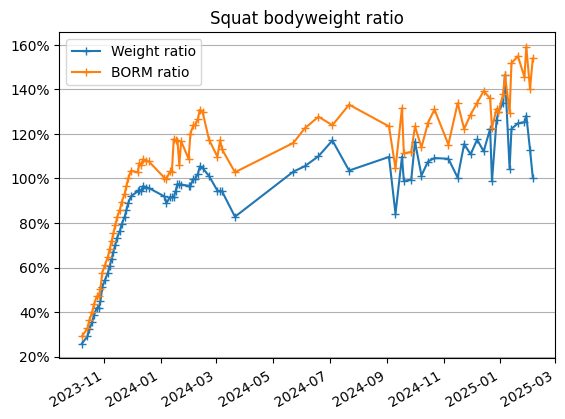

Weight        Borm
2025-02-05  100.426050  153.933049
2025-02-02  112.942613  140.204623
2025-01-29  128.205128  159.151194
2025-01-27  125.305623  145.516208
2025-01-20  124.771759  154.889080
...                ...         ...
2023-10-21   38.620824   43.448427
2023-10-19   35.427377   39.855799
2023-10-16   32.240796   36.270896
2023-10-14   29.037207   32.666857
2023-10-08   25.865645   29.098851

[82 rows x 2 columns]

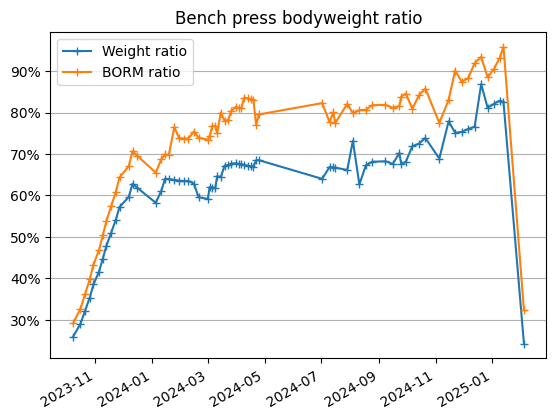

Weight       Borm
2025-02-04  24.257126  32.342834
2025-01-13  82.551977  95.866812
2025-01-09  82.872928  93.232044
2025-01-03  82.116788  90.611628
2024-12-27  81.129808  88.505245
...               ...        ...
2023-10-30  38.498789  43.311138
2023-10-26  35.340187  39.757711
2023-10-21  32.184020  36.207022
2023-10-16  29.016717  32.643806
2023-10-08  25.865645  29.098851

[71 rows x 2 columns]

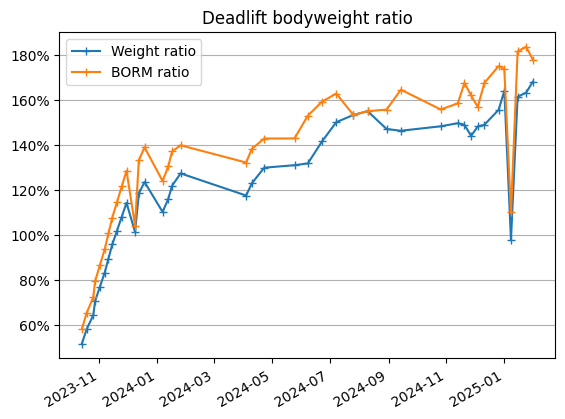

Weight        Borm
2025-01-31  168.195719  178.089584
2025-01-24  163.339383  183.756806
2025-01-15  161.486898  181.672761
2025-01-08   97.759674  109.979633
2025-01-01  164.133739  173.788664
...                ...         ...
2023-11-02   76.916565   86.531135
2023-10-28   70.630709   79.459548
2023-10-26   64.254886   72.286747
2023-10-19   57.972071   65.218580
2023-10-14   51.621701   58.074413

[41 rows x 2 columns]

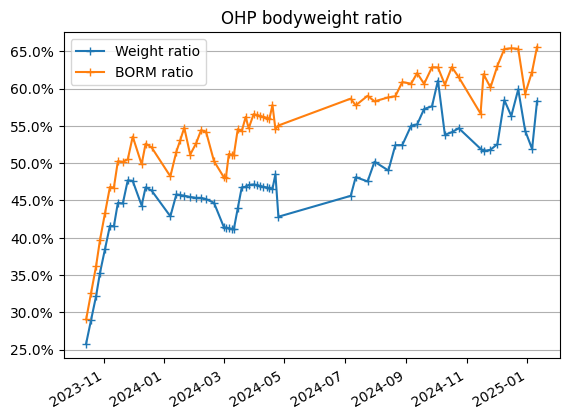

Weight       Borm
2025-01-11  58.306056  65.594313
2025-01-06  51.892552  62.271062
2024-12-30  54.347826  59.288538
2024-12-23  59.880240  65.323898
2024-12-16  56.312982  65.395721
...               ...        ...
2023-11-02  38.458282  43.265568
2023-10-28  35.315355  39.729774
2023-10-24  32.150050  36.168806
2023-10-19  28.986036  32.609290
2023-10-14  25.810850  29.037207

[66 rows x 2 columns]

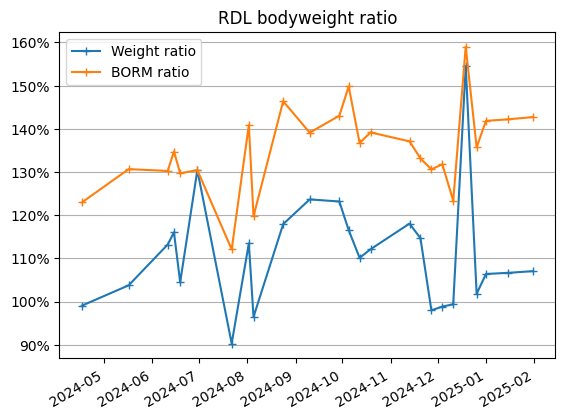

Weight        Borm
2025-01-31  107.033639  142.711519
2025-01-15  106.642291  142.189722
2025-01-01  106.382979  141.843972
2024-12-26  101.796407  135.728543
2024-12-19  154.577883  158.994394
...                ...         ...
2024-06-19  104.483926  129.704183
2024-06-15  116.022099  134.735341
2024-06-11  113.197129  130.238580
2024-05-17  103.762708  130.664151
2024-04-17   99.044512  122.951808

[25 rows x 2 columns]

In [14]:
bw_ratio_plot('Squat')
bw_ratio_plot('Bench press')
bw_ratio_plot('Deadlift')
bw_ratio_plot('OHP')
bw_ratio_plot('RDL')

In [15]:
def dots_calc(bw, weight_lifted):
    # https://www.inchcalculator.com/lifting-strength-calculator/
    dots_coeff = [-0.000001093, 0.0007391293, -0.1918759221, 24.0900756, -307.75076]
    i_list = reversed(range(5))
    dots_terms = [ p*(bw**q) for p, q in zip(dots_coeff,i_list) ]
    dots = weight_lifted * 500 / sum(dots_terms)
    return dots

def dotsplot(lift_name):
    lift_df = lift_df_dict[lift_name]
    # going to make a list of bodyweights at each of the dates in lift_df
    bw_list = []
    dots_list = []

    for date, row in lift_df.iterrows():
        bw = weight_at_date(date, weight_df)
        bw_list.append(bw)

        # USE EITHER WEIGHT OR BORM
        # weight = lift_df.loc[date,'Weight']
        weight = lift_df.loc[date,'Borm']

        dots = dots_calc(bw, weight)
        # print(f"bw={bw},result={weight},dots={dots}")
        dots_list.append(dots)
        
    plt.plot(lift_df.index, dots_list, '+-', label = "DOTS (from BORM)")
    plt.plot(lift_df.index, lift_df['Borm'], '+-', label = "BORM")

    plt.grid(axis = 'y')
    plt.legend()
    plotname = f"{lift_name} DOTS"
    plt.title(plotname)
    plt.savefig(rf'{results_directory}\figures\{plotname}.png', dpi=300, bbox_inches='tight')
    plt.gcf().autofmt_xdate()
    plt.show()

In [16]:
# dotsplot('Squat')
# dotsplot('Bench press')
# dotsplot('Deadlift')
# dotsplot('OHP')
# dotsplot('RDL')

In [17]:
def calisthenic(lift_name, weight_df):
    lift_df = lift_df_dict[lift_name]

    for date in lift_df.index:
        weight = weight_at_date(date, weight_df)
        lift_df.loc[date,'Weight'] = weight

        reps = lift_df.loc[date,'Reps']
        lift_df.loc[date,'Borm'] = borm_calc(reps, str(weight))

    plt.plot(lift_df.index,lift_df['Weight'], '+-', label = "Body weight")
    plt.plot(lift_df.index,lift_df['Borm'], '+-', label = "BORM")

    plt.grid(axis = 'y')
    plt.legend()
    plotname = f"{lift_name} calisthenic"
    plt.title(plotname)
    plt.gcf().autofmt_xdate()
    plt.savefig(rf'{results_directory}\figures\{plotname}.png', dpi=300, bbox_inches='tight')
    plt.show()

    display(lift_df)

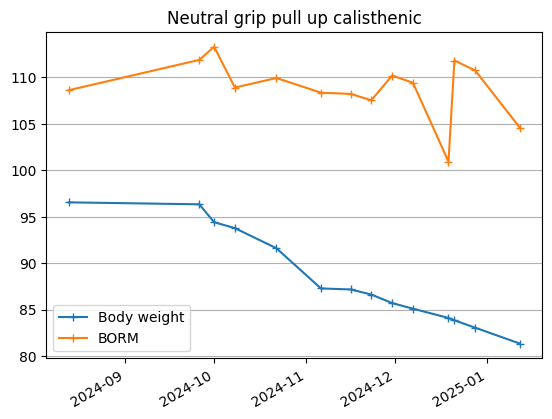

Weight        Borm  Reps
2025-01-12  81.350000  104.592857   9.0
2024-12-28  83.050000  110.733333  10.0
2024-12-21  83.850000  111.800000  10.0
2024-12-19  84.100000  100.920000   7.0
2024-12-07  85.100000  109.414286   9.0
...               ...         ...   ...
2024-10-22  91.600000  109.920000   7.0
2024-10-08  93.766667  108.890323   6.0
2024-10-01  94.400000  113.280000   7.0
2024-09-26  96.328571  111.865438   6.0
2024-08-13  96.540000  108.607500   5.0

[14 rows x 3 columns]

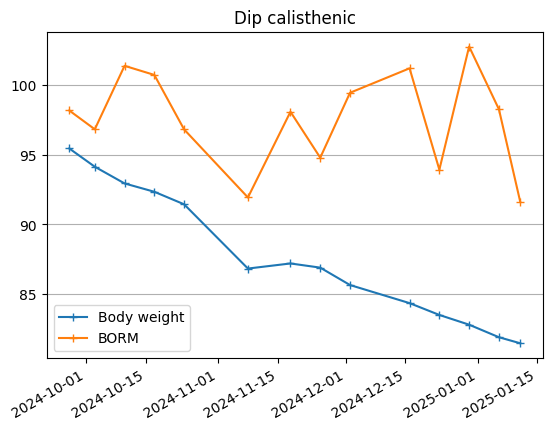

Weight        Borm  Reps
2025-01-11  81.466667   91.650000   5.0
2025-01-06  81.900000   98.280000   7.0
2024-12-30  82.800000  102.786207   8.0
2024-12-23  83.500000   93.937500   5.0
2024-12-16  84.350000  101.220000   7.0
...               ...         ...   ...
2024-10-24  91.450000   96.829412   3.0
2024-10-17  92.350000  100.745455   4.0
2024-10-10  92.950000  101.400000   4.0
2024-10-03  94.150000   96.840000   2.0
2024-09-27  95.462500   98.190000   2.0

[14 rows x 3 columns]

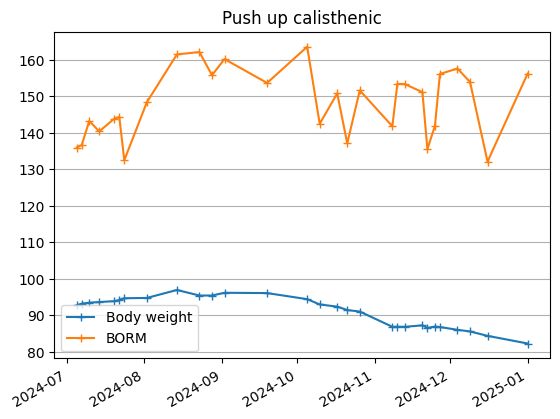

Weight        Borm  Reps
2025-01-01  82.250000  156.200975  27.0
2024-12-16  84.350000  132.100535  17.0
2024-12-09  85.550000  153.921560  24.0
2024-12-04  86.000000  157.595000  25.0
2024-11-27  86.766667  156.110587  24.0
...               ...         ...   ...
2024-07-20  93.858333  143.866053  16.0
2024-07-14  93.608333  140.365696  15.0
2024-07-10  93.441667  143.227387  16.0
2024-07-07  93.175000  136.613185  14.0
2024-07-05  92.725000  135.953395  14.0

[29 rows x 3 columns]

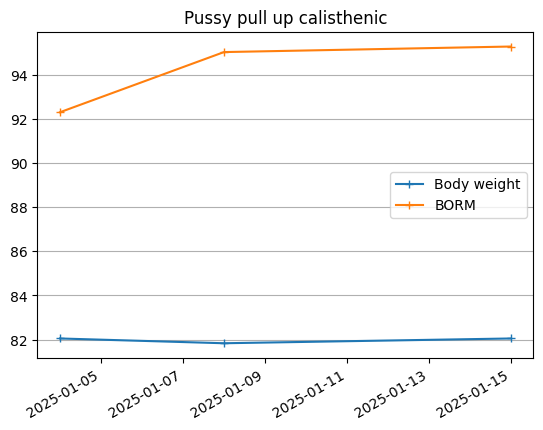

Weight       Borm  Reps
2025-01-15  82.050000  95.283871   6.0
2025-01-08  81.833333  95.032258   6.0
2025-01-04  82.050000  92.306250   5.0

In [18]:
calisthenic("Neutral grip pull up", weight_df)
calisthenic("Dip", weight_df)
calisthenic("Push up", weight_df)
calisthenic("Pussy pull up", weight_df)

In [19]:
def combined_plot(liftlist, max_on, borm_on, goals=False):

    legend = []
    # initialise dates
    max_date = pd.Timestamp('1970-1-1')
    min_date = pd.Timestamp('2170-1-1')

    name_qualifiers = ""
    if max_on:
        name_qualifiers = name_qualifiers + "max-"
    if borm_on:
        name_qualifiers = name_qualifiers + "borm-"

    for i,lift in enumerate(liftlist):
        
        lift_df = lift_df_dict[lift].copy()
        UniCheck = lift_info_df.loc[lift, 'UniCheck']
        
        if goals != False:
            lift_df['Weight'] = lift_df['Weight'] / goals[i] * 100
            lift_df['Borm'] =  lift_df['Borm'] / goals[i] * 100

        x = lift_df.index
        max_date = max(max(x),max_date)
        min_date = min(min(x),min_date)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator())

        if max_on:
            y1 = lift_df['Weight']
            plt.plot(x,y1,"+-")
            if UniCheck:
                legend.extend([f'{lift} left max', f'{lift} right max'])
            else:
                legend.append(f'{lift} max')
        
        if borm_on:
            y2 = lift_df['Borm']
            plt.plot(x,y2,"+-")
            if UniCheck:
                legend.extend([f'{lift} left BORM', f'{lift} right BORM'])
            else:
                legend.append(f'{lift} BORM')

    # makes dates diagonal
    plt.gcf().autofmt_xdate()

    plt.legend(legend)

    # organise the x ticks
    x_range = (max_date - min_date).days
    max_ticks = 12
    min_interval = 7
    interval = max( int(np.ceil(x_range/(max_ticks*min_interval))*min_interval), min_interval)
    tick_count = int(np.floor(x_range/interval))

    ax=plt.gca()
    ax.set_xticks([min_date + dt.timedelta(days=i*interval) for i in range(tick_count+1)])

    # plot horizontal lines at each 20 kg
    # https://stackoverflow.com/questions/61347471/is-there-a-way-to-plot-multiple-horizontal-lines-using-hlines-function-in-a-si
    # https://stackoverflow.com/questions/52743065/how-to-plot-without-extending-axis-limits
    plt.autoscale(False)
    [ax.axhline(y=i, linestyle='--', color='lightblue', zorder=0) for i in range(20,220,20)]

    plotname = 'combined-' + name_qualifiers + '-'.join(map(str, liftlist))

    if goals != False:
        plt.axis([None, None, 0, 100])
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plotname = 'goals-' + plotname + '-' + '-'.join(map(str, goals))

    plt.savefig(rf'{results_directory}\figures\{plotname}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

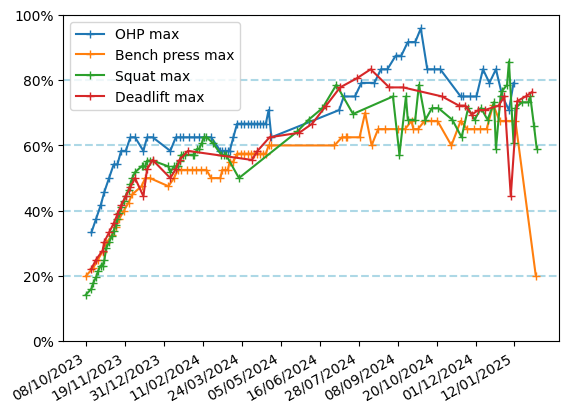

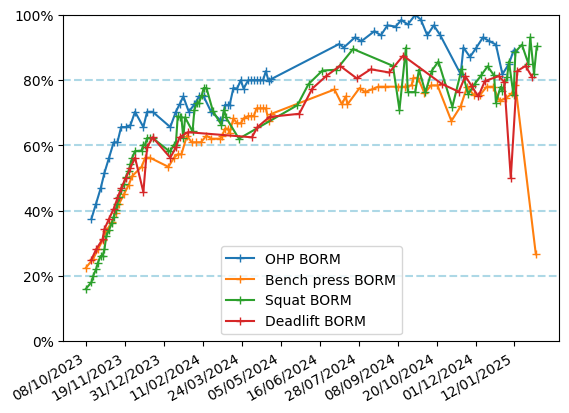

In [20]:
goals = [60,100,140,180]
combined_plot(["OHP","Bench press","Squat","Deadlift"],1,0,goals)
combined_plot(["OHP","Bench press","Squat","Deadlift"],0,1,goals)

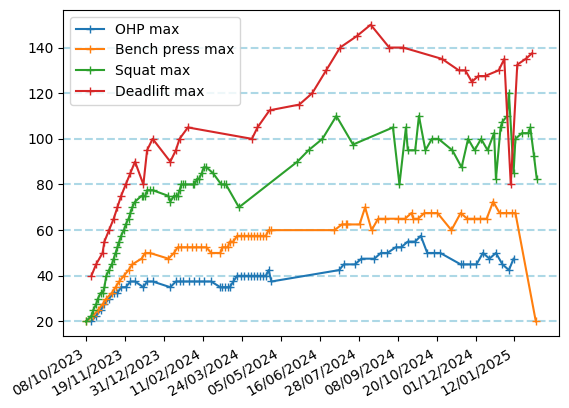

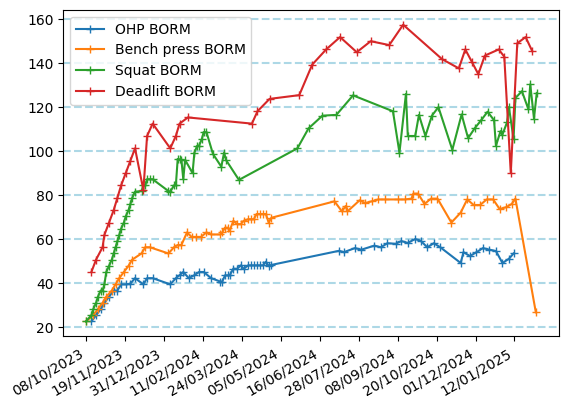

In [21]:
combined_plot(["OHP","Bench press","Squat","Deadlift"],1,0)
combined_plot(["OHP","Bench press","Squat","Deadlift"],0,1)

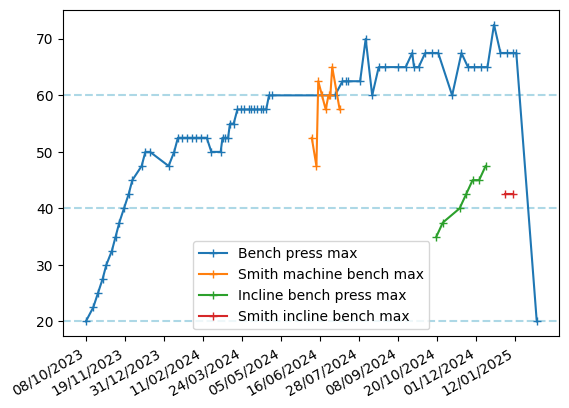

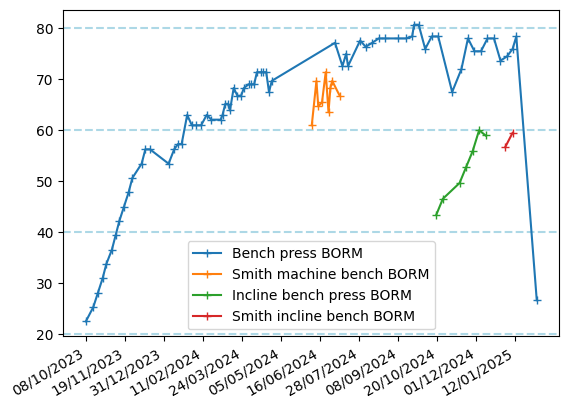

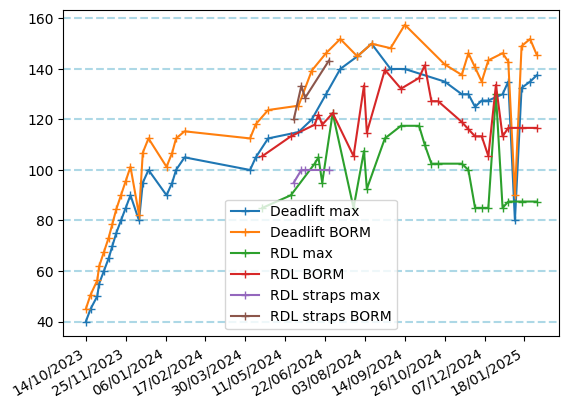

In [22]:
combined_plot(["Bench press","Smith machine bench","Incline bench press", "Smith incline bench"],1,0)
combined_plot(["Bench press","Smith machine bench","Incline bench press", "Smith incline bench"],0,1)
combined_plot(["Deadlift","RDL","RDL straps"],1,1)